In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy

In [3]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
#0.1 of 30sec is 3 sec
#try with 0.05 window

def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [6]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [7]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,y_train,random_state=42,test_size=0.1, stratify=y_train)
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)
    X_valid, y_valid = split_convert(X_valid, y_valid)

    return X_train, X_test, y_train, y_test, X_valid, y_valid

In [8]:
# Parameters
gtzan_dir = '../data/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, X_test, y_train, y_test, X_valid, y_valid = read_data(gtzan_dir, genres, song_samples)

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01361084 0.02810669 0.03515625 ... 0.09667969 0.09692383 0.09399414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.43545532 0.4111023  0.39978027 ... 0.02554321 0.01922607 0.0196228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09356689  0.09411621  0.09457397 ... -0.09121704 -0.07785034
 -0.08377075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0914917  -0.0874939   0.16366577 ... -0.04418945 -0.03259277
 -0.04522705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.36462402 0.6788635  0.66937256 ... 0.10751343 0.11825562 0.13479614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02664185 -0.03216553 -0.01217651 ...  0.12194824  0.1232605
  0.13897705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.20657349  0.23364258  0.21484375 ... -0.48077393 -0.4296875
 -0.39492798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.21740723 -0.33261108 -0.44311523 ...  0.20178223  0.19711304
  0.19985962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.42385864 -0.4548645  -0.4559021  ... -0.44110107 -0.46972656
 -0.53726196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07894897 0.13638306 0.13336182 ... 0.04412842 0.02151489 0.03271484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04959106 -0.03012085 -0.01266479 ... -0.17871094 -0.14190674
 -0.11621094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04486084 0.03076172 0.02804565 ... 0.04296875 0.09405518 0.12127686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00909424 -0.01065063 -0.00079346 ... -0.13931274 -0.14572144
 -0.09576416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03335571 -0.05078125 -0.05722046 ... -0.00680542 -0.00610352
  0.00125122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.383667    0.33795166  0.3093567  ...  0.02380371 -0.01464844
 -0.02285767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2281189  -0.2987671  -0.2564087  ... -0.02706909  0.01150513
  0.01025391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03961182 -0.04959106 -0.02841187 ... -0.05505371 -0.06018066
 -0.06634521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02563477 -0.0401001  -0.0090332  ... -0.02310181 -0.02670288
 -0.02664185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06588745 0.06848145 0.06866455 ... 0.06619263 0.06616211 0.06164551] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00543213 -0.00610352 -0.00640869 ... -0.00808716  0.00018311
  0.01077271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.05096436 0.05499268 0.06634521 ... 0.00506592 0.01748657 0.00845337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04406738 -0.03851318 -0.09246826 ...  0.00793457  0.00564575
 -0.01361084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.09545898 0.11349487 0.07800293 ... 0.04650879 0.02944946 0.02050781] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0296936  -0.02420044  0.02090454 ... -0.04309082 -0.05593872
 -0.04486084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0227356  0.03765869 0.06750488 ... 0.20095825 0.18579102 0.17297363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10830688 -0.10369873 -0.1156311  ... -0.15185547 -0.12210083
 -0.11068726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.24002075  0.26083374  0.21240234 ... -0.13708496 -0.13848877
 -0.17861938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14181519 -0.1053772  -0.06442261 ... -0.06341553 -0.04974365
 -0.03588867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.2828064   0.3343506   0.2027893  ... -0.17855835 -0.15075684
 -0.10992432] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03494263 -0.01281738 -0.01034546 ... -0.10339355 -0.08535767
 -0.05041504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02859497  0.02639771  0.00363159 ... -0.01205444 -0.01800537
 -0.00762939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00805664 0.00442505 0.0071106  ... 0.01608276 0.02484131 0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01052856 -0.01919556 -0.00799561 ...  0.05328369  0.06253052
  0.04147339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.16659546 -0.23223877 -0.2239685  ...  0.03973389  0.16531372
  0.19958496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04931641  0.04824829  0.10675049 ... -0.02627563  0.08105469
  0.01049805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.12838745  0.07232666  0.08099365 ... -0.05734253 -0.10968018
 -0.15646362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06237793 -0.07580566 -0.07092285 ... -0.00436401 -0.00518799
 -0.01138306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15106201 -0.15975952 -0.16281128 ... -0.07269287 -0.04690552
 -0.01364136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1423645  -0.2215271  -0.11950684 ...  0.02423096  0.12643433
  0.14456177] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00839233 -0.07400513 -0.1491394  ...  0.11923218  0.05984497
  0.05804443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00198364  0.00210571  0.00808716 ...  0.09164429  0.09506226
  0.10552979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09048462  0.12347412  0.10501099 ... -0.03317261 -0.01504517
 -0.01031494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.21234131 0.27944946 0.31329346 ... 0.0574646  0.06558228 0.06787109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.15951538  0.14984131  0.16900635 ... -0.30633545 -0.41073608
 -0.5174866 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06253052 0.05499268 0.0423584  ... 0.0305481  0.03683472 0.02792358] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.16101074 0.16558838 0.17059326 ... 0.03207397 0.01858521 0.0015564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03485107  0.03762817  0.03152466 ... -0.0140686  -0.02337646
 -0.02520752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00704956 -0.0093689  -0.00692749 ... -0.06436157 -0.07290649
 -0.07226562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04122925 -0.06765747 -0.11651611 ... -0.3848877  -0.34594727
 -0.27093506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07354736  0.15145874  0.18963623 ... -0.35028076 -0.30923462
 -0.11489868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.3189392  -0.3664856  -0.28936768 ...  0.08328247  0.07391357
  0.05606079] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.14553833  0.13967896  0.10794067 ... -0.0536499  -0.04263306
 -0.04055786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08859253 -0.03924561  0.02249146 ...  0.18930054  0.17330933
  0.14401245] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03216553 -0.03530884 -0.04284668 ...  0.04382324  0.034729
  0.02835083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10934448  0.10092163  0.10345459 ... -0.08410645 -0.05319214
 -0.01312256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08755493 -0.11050415 -0.12445068 ...  0.06015015  0.03649902
  0.01950073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00268555 -0.00872803 -0.02944946 ... -0.05291748 -0.06271362
 -0.06912231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.20748901 -0.08297729 -0.12493896 ...  0.10922241  0.37512207
  0.59732056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.38656616 -0.45025635 -0.29974365 ...  0.19012451  0.24615479
  0.29019165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.5305481   0.40063477  0.24465942 ... -0.0123291   0.00338745
  0.1326294 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.20697021  0.20822144  0.19677734 ... -0.02285767 -0.05230713
 -0.04891968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08761597  0.08309937  0.01361084 ... -0.14227295 -0.17318726
 -0.13391113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04534912 -0.06845093 -0.05279541 ...  0.01272583 -0.04003906
 -0.07199097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05456543  0.06298828  0.07562256 ...  0.00424194 -0.01785278
 -0.02828979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08129883 -0.08914185 -0.10125732 ... -0.00512695  0.00274658
  0.00650024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02627563 -0.00897217  0.01315308 ...  0.01919556  0.01535034
  0.00534058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04214478  0.04418945  0.04937744 ... -0.05856323 -0.05749512
 -0.05093384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00488281 -0.01522827 -0.02285767 ...  0.1696167   0.14840698
  0.12188721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04397583 -0.04101562 -0.03756714 ...  0.0118103   0.0098877
  0.02456665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.22000122 0.2192688  0.24169922 ... 0.34628296 0.35336304 0.35968018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.50335693  0.42556763  0.2616577  ...  0.13375854  0.05032349
 -0.06814575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.36257935 0.34487915 0.33392334 ... 0.9873657  0.9873657  0.98739624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0821228  0.05004883 0.01202393 ... 0.1510315  0.13354492 0.12167358] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02529907 -0.03985596 -0.0249939  ...  0.40350342  0.393219
  0.38186646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.13165283 0.14086914 0.17687988 ... 0.11065674 0.10583496 0.10525513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04022217 -0.0458374  -0.03765869 ...  0.02313232  0.03579712
  0.03411865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06155396 -0.05285645 -0.05908203 ...  0.07064819  0.15164185
  0.07778931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.034729    0.0402832   0.03970337 ... -0.00344849 -0.00564575
 -0.01849365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06506348 -0.06375122 -0.08627319 ...  0.00216675 -0.0133667
 -0.06832886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06951904 -0.04144287 -0.02206421 ...  0.12243652 -0.05996704
 -0.05526733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07757568 -0.04681396 -0.04223633 ...  0.04638672  0.08029175
  0.05615234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.22039795 0.16629028 0.10519409 ... 0.08013916 0.14086914 0.1918335 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08377075 -0.1472168  -0.2767334  ... -0.00585938  0.00216675
  0.00515747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.2180481   0.2142334   0.19018555 ... -0.02648926 -0.02944946
  0.03262329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05407715 -0.13406372 -0.09524536 ...  0.27850342  0.2350769
  0.2027893 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03451538 0.02581787 0.04586792 ... 0.03329468 0.17590332 0.36798096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.16357422 -0.18377686 -0.14898682 ...  0.08248901  0.08041382
  0.05032349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0062561  -0.0045166  -0.00256348 ...  0.00323486  0.00109863
 -0.00082397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00250244  0.00189209  0.00140381 ... -0.00195312 -0.00039673
  0.00100708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00222778 -0.0032959  -0.00350952 ... -0.00866699 -0.01159668
 -0.0138855 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1906128  -0.1880188  -0.23449707 ...  0.13378906  0.14181519
  0.04681396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.44351196  0.6738281   0.4211731  ... -0.11276245 -0.1104126
 -0.14331055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07870483 0.08258057 0.05841064 ... 0.11566162 0.04956055 0.050354  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.13876343  0.1484375   0.15863037 ... -0.76519775 -0.6185913
 -0.5615845 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1472168   0.11264038 -0.05352783 ...  0.08309937  0.02386475
  0.05844116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.8031616  -0.3496399  -0.6847229  ...  0.09326172  0.07510376
  0.05316162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2090149  -0.28433228 -0.32382202 ...  0.03668213  0.05654907
 -0.0171814 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.20755005 -0.17459106 -0.09918213 ... -0.1637268  -0.15948486
 -0.15066528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04284668  0.02774048 -0.0065918  ...  0.15707397  0.17306519
  0.17529297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05288696  0.0496521   0.08013916 ... -0.05181885 -0.11270142
 -0.10958862] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03588867 -0.03036499 -0.0239563  ...  0.06283569  0.02926636
  0.02420044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05938721 -0.01882935 -0.02944946 ... -0.15249634 -0.1366272
 -0.09899902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03335571 -0.05047607 -0.05081177 ... -0.11795044 -0.127594
 -0.1300354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12261963 -0.11965942 -0.11785889 ...  0.18606567  0.18106079
  0.18093872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13531494 -0.13833618 -0.1394043  ... -0.00073242  0.00485229
  0.00521851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02908325  0.02432251 -0.01422119 ...  0.4727173   0.4520874
  0.15084839] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1404419  -0.1463623  -0.14559937 ... -0.48049927 -0.52731323
 -0.5688782 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.43389893 -0.6612549  -0.63412476 ... -0.32125854 -0.4211731
 -0.40490723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2672119  -0.26296997 -0.23422241 ... -0.13198853 -0.28482056
 -0.4069214 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07012939 -0.06988525 -0.07287598 ... -0.03210449 -0.08981323
 -0.10580444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.41397095 -0.41638184 -0.45877075 ... -0.09286499 -0.1267395
 -0.1715393 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.1411438  0.17422485 0.13986206 ... 0.03527832 0.03762817 0.03341675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01916504 -0.04623413 -0.0696106  ... -0.06222534 -0.07891846
 -0.08032227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03686523 -0.06939697 -0.09130859 ... -0.00012207  0.01733398
  0.04406738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01062012 -0.01379395 -0.01528931 ...  0.04205322  0.0536499
  0.05703735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09890747  0.08828735  0.0713501  ... -0.00143433 -0.00430298
  0.01147461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06463623  0.06365967  0.04779053 ... -0.02648926 -0.26898193
 -0.48260498] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10406494 -0.06118774 -0.02362061 ... -0.01116943  0.00772095
  0.00152588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.11697388 0.08929443 0.09066772 ... 0.06817627 0.05877686 0.04928589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01342773 0.04510498 0.0201416  ... 0.2539673  0.21798706 0.10195923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04031372  0.03149414  0.02734375 ... -0.0553894  -0.02035522
 -0.01199341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09585571 -0.08001709 -0.07498169 ... -0.0458374  -0.04678345
 -0.03643799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07595825  0.00143433  0.02380371 ... -0.02209473 -0.01480103
 -0.00799561] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05233765  0.02755737  0.00036621 ... -0.00033569 -0.00466919
 -0.00485229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05252075 -0.07385254 -0.08352661 ...  0.00119019  0.00454712
  0.00439453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00158691  0.00387573  0.00839233 ... -0.01785278 -0.01702881
 -0.01547241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09735107  0.12475586  0.11181641 ... -0.22827148 -0.33480835
 -0.41906738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07281494 -0.00500488 -0.06283569 ... -0.04833984 -0.04467773
 -0.0255127 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00317383  0.01080322 -0.02145386 ... -0.02963257  0.01156616
  0.04135132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.22949219 -0.20394897 -0.21939087 ... -0.11999512 -0.1083374
 -0.04623413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.28805542 -0.25820923 -0.20800781 ... -0.1126709  -0.13186646
  0.10427856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04394531 -0.07855225 -0.13128662 ...  0.02536011 -0.03009033
 -0.05828857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01397705 -0.0279541  -0.02035522 ... -0.0038147   0.0194397
  0.04122925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.12628174  0.06765747 -0.07324219 ...  0.16394043  0.13568115
  0.0496521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00192261  0.00180054  0.01339722 ...  0.01187134  0.0369873
  0.04705811] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00650024 -0.00476074 -0.00234985 ...  0.00595093  0.00338745
  0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00787354  0.0065918   0.00521851 ... -0.01928711 -0.01882935
 -0.01947021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00442505 -0.01095581 -0.01480103 ...  0.00836182  0.00869751
  0.00875854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07250977  0.05847168  0.03005981 ... -0.10317993 -0.12124634
 -0.12530518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.21206665  0.22683716  0.21374512 ... -0.20129395 -0.224823
 -0.24465942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12329102 -0.10598755 -0.06903076 ...  0.01846313  0.02798462
  0.01895142] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07907104 -0.10626221 -0.04922485 ... -0.07852173 -0.07443237
 -0.07189941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.14697266  0.14978027  0.15267944 ... -0.08401489 -0.0710144
 -0.06439209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06881714 -0.06652832 -0.06356812 ...  0.07821655  0.09674072
  0.08218384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.27545166 -0.2828064  -0.19973755 ... -0.21386719 -0.2750244
 -0.3279419 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03118896 -0.02615356  0.03070068 ... -0.09329224 -0.14346313
 -0.08938599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.3119812  -0.25976562 -0.19717407 ...  0.01754761  0.00518799
  0.01373291] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02740479 -0.02145386 -0.02896118 ...  0.07284546  0.06106567
  0.06085205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.3173523   0.37017822  0.59661865 ... -0.24078369 -0.17745972
 -0.22979736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04367065 0.03085327 0.05865479 ... 0.04058838 0.03930664 0.04376221] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.29037476  0.3282776   0.32278442 ... -0.0411377  -0.04299927
 -0.03393555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08831787  0.00970459 -0.01980591 ... -0.21762085 -0.21511841
 -0.14785767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03356934 -0.04205322 -0.04205322 ...  0.09567261  0.08410645
  0.05786133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.20727539 -0.1993103  -0.15213013 ... -0.13760376 -0.15994263
 -0.1850586 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0463562  -0.10397339 -0.15438843 ...  0.10266113  0.11328125
  0.12481689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.21224976 -0.23410034 -0.24594116 ... -0.07843018 -0.07919312
 -0.10272217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00744629  0.00421143  0.00137329 ... -0.06256104  0.01730347
 -0.05218506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09130859  0.18261719  0.22225952 ... -0.09552002 -0.1020813
 -0.12289429] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12069702 -0.05480957 -0.02484131 ...  0.04949951  0.09237671
  0.16864014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.34561157 0.31185913 0.28485107 ... 0.21600342 0.20336914 0.22061157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00082397  0.00814819  0.01199341 ... -0.14364624 -0.1923523
 -0.21252441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15701294 -0.15576172 -0.13497925 ... -0.02566528 -0.0369873
 -0.06259155] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08047485  0.06942749  0.06549072 ... -0.07305908 -0.07012939
 -0.06417847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0135498  -0.00457764 -0.01815796 ...  0.00759888  0.00286865
 -0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04159546 -0.09088135 -0.10888672 ...  0.05978394  0.03747559
  0.00726318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01373291 -0.01107788 -0.00823975 ...  0.04626465  0.03112793
  0.01263428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00323486 -0.00354004 -0.0038147  ... -0.00442505 -0.00604248
 -0.00772095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00619507 0.02075195 0.04547119 ... 0.05303955 0.04644775 0.03927612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.5417175  -0.5853882  -0.6397095  ...  0.250885    0.32156372
  0.29818726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10754395  0.19454956  0.23739624 ... -0.11480713 -0.1184082
 -0.05551147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.25424194  0.2163086   0.23199463 ... -0.24935913 -0.236969
 -0.06295776] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.58078    0.59210205 0.63378906 ... 0.30630493 0.3718872  0.30136108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.22454834 -0.21875    -0.09539795 ...  0.05163574  0.02502441
 -0.01705933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.23770142  0.25387573  0.08380127 ... -0.07910156 -0.06600952
 -0.02905273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06890869 -0.10128784 -0.07559204 ... -0.06072998 -0.06848145
 -0.07791138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04458618 -0.04397583 -0.04199219 ... -0.0012207  -0.00228882
 -0.00363159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08865356 -0.1031189  -0.11953735 ... -0.01434326 -0.01455688
 -0.0151062 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01248169 -0.01358032 -0.0144043  ... -0.6989746  -0.7453003
 -0.70166016] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00167847 -0.00164795
 -0.00170898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.02206421 -0.0072937
 -0.0213623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10580444  0.17520142  0.16888428 ... -0.10760498 -0.06585693
 -0.07409668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01654053 -0.0078125  -0.00500488 ... -0.19631958 -0.23049927
 -0.24035645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10681152 -0.1282959  -0.11529541 ... -0.05126953 -0.0531311
 -0.03295898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00216675  0.00375366  0.00521851 ... -0.02203369 -0.01473999
 -0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01928711 -0.02194214 -0.02224731 ... -0.04977417 -0.04537964
 -0.03765869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00521851  0.01052856  0.01113892 ... -0.03463745 -0.02139282
 -0.0067749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.12045288  0.10412598  0.09307861 ... -0.0819397  -0.0736084
 -0.06433105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00033569  0.0078125   0.01715088 ...  0.05563354  0.05761719
  0.05395508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05630493 -0.04663086 -0.04354858 ... -0.02810669 -0.02920532
 -0.02542114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02407837 -0.06161499 -0.04367065 ...  0.10333252  0.11978149
  0.0218811 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.30059814 -0.30184937 -0.01852417 ...  0.06680298  0.17584229
  0.21020508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04275513  0.00140381 -0.0246582  ... -0.00500488 -0.02856445
 -0.02856445] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04800415 -0.0289917   0.03903198 ... -0.250885   -0.24725342
 -0.2374878 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.26174927 -0.23150635 -0.20751953 ...  0.23477173  0.22598267
  0.20324707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.31311035 -0.27078247 -0.25698853 ... -0.14511108 -0.1472168
 -0.14752197] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01431274 -0.01495361 -0.01678467 ...  0.17480469  0.17001343
  0.16519165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.23309326 0.25265503 0.24996948 ... 0.28155518 0.2954712  0.2854309 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.16152954 0.16397095 0.16830444 ... 0.00198364 0.00839233 0.01611328] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00180054  0.0062561  -0.03903198 ... -0.1689148  -0.15661621
 -0.14428711] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.26611328 -0.24856567 -0.24328613 ...  0.07284546  0.06964111
  0.06661987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13467407 -0.11685181 -0.11190796 ... -0.0730896  -0.04925537
 -0.02468872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00405884  0.00476074  0.00540161 ... -0.00585938 -0.00494385
 -0.00396729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00241089  0.00283813  0.00314331 ... -0.00030518 -0.00036621
 -0.00061035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00305176 -0.00216675 -0.00149536 ...  0.01196289  0.00930786
  0.00665283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.13320923 0.15203857 0.13302612 ... 0.13418579 0.15274048 0.16586304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11569214  0.15637207  0.18951416 ... -0.02706909  0.02908325
  0.09222412] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.11483765 0.09170532 0.12869263 ... 0.01187134 0.03564453 0.04232788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01153564  0.01080322  0.01370239 ... -0.16708374 -0.13357544
 -0.11141968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11514282 -0.10916138 -0.10101318 ... -0.1816101  -0.17529297
 -0.23242188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10305786 -0.11395264 -0.11199951 ...  0.01931763  0.02584839
  0.01141357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00585938 0.00708008 0.00802612 ... 0.00170898 0.0015564  0.00125122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01379395 -0.0128479  -0.01168823 ... -0.01742554 -0.0168457
 -0.01260376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00073242  0.00045776  0.00106812 ... -0.01144409 -0.00753784
 -0.00561523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.42648315 -0.3821106  -0.22988892 ...  0.291687    0.32678223
  0.2371521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.32321167  0.24005127  0.04776001 ... -0.06344604 -0.02038574
  0.01296997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0869751  -0.26843262  0.01266479 ... -0.08843994 -0.15234375
  0.10678101] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.35153198  0.29071045  0.184906   ...  0.02996826 -0.02206421
 -0.06469727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02178955  0.01306152  0.0317688  ...  0.03018188 -0.06512451
 -0.07034302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04620361  0.20184326  0.25854492 ...  0.00057983 -0.06417847
 -0.03192139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.20785522 -0.15148926 -0.090271   ... -0.33517456 -0.22320557
 -0.14404297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.3053894  0.22113037 0.1637268  ... 0.19659424 0.16293335 0.14755249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06741333 -0.16012573 -0.22421265 ...  0.11703491  0.184906
  0.20605469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0486145  0.03488159 0.05236816 ... 0.01400757 0.01831055 0.02371216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1105957   0.09719849  0.08584595 ... -0.01480103 -0.00283813
  0.00610352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04043579 0.05838013 0.06860352 ... 0.15789795 0.22555542 0.22515869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14672852 -0.01367188  0.35598755 ...  0.0319519   0.13372803
  0.14620972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01251221 -0.02078247  0.00802612 ...  0.18283081  0.15106201
 -0.10739136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.2515564   0.29159546  0.2824707  ... -0.33874512  0.11303711
  0.42010498] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02685547  0.00582886  0.02127075 ... -0.05807495  0.01116943
  0.01367188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.20019531 0.23791504 0.25546265 ... 0.18930054 0.2770691  0.28381348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04318237 -0.16946411 -0.2675476  ... -0.03372192 -0.00912476
  0.03378296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01419067 -0.01144409 -0.0177002  ... -0.0213623  -0.040802
 -0.03512573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0249939  0.03469849 0.06323242 ... 0.0723877  0.08218384 0.09161377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03051758 -0.02429199 -0.03833008 ...  0.00238037  0.00723267
  0.00491333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00439453 -0.01071167 -0.08081055 ... -0.11862183 -0.12072754
 -0.12130737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.12496948  0.25756836  0.33215332 ... -0.11914062 -0.1137085
 -0.0796814 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11984253 -0.12216187 -0.1251831  ...  0.09042358  0.2220459
  0.27017212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.22155762 -0.08691406 -0.00802612 ...  0.730896    0.7914429
  0.88256836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.24020386  0.2154541   0.23239136 ... -0.0703125  -0.05792236
 -0.07723999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.8840332  0.89297485 0.9496765  ... 0.4060974  0.426239   0.41818237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04586792 0.05648804 0.06726074 ... 0.09747314 0.10195923 0.0925293 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06054688 0.04678345 0.05947876 ... 0.02105713 0.02059937 0.01763916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08001709  0.07363892  0.06729126 ... -0.025177   -0.02844238
 -0.02841187] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.15963745  0.16271973  0.15377808 ... -0.28744507 -0.2354126
 -0.19418335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04760742 -0.04592896 -0.04568481 ...  0.00210571 -0.00582886
 -0.0173645 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.16052246 -0.15609741 -0.15560913 ...  0.07034302  0.7345581
 -0.9059143 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12442017 -0.20019531 -0.14730835 ...  0.12319946  0.13397217
  0.08764648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02679443  0.06332397 -0.10217285 ...  0.20233154  0.20605469
  0.25888062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02685547 0.0032959  0.02536011 ... 0.04858398 0.08868408 0.16604614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03720093  0.04489136  0.05780029 ... -0.01602173  0.00787354
  0.0206604 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03787231 0.04629517 0.06582642 ... 0.04296875 0.04315186 0.02975464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09887695 -0.11813354 -0.1749878  ...  0.18734741  0.27374268
  0.31860352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.17214966 -0.0947876  -0.00442505 ... -0.12149048 -0.17092896
 -0.08770752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17727661 -0.19277954 -0.2602539  ...  0.00592041  0.02175903
  0.03384399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10070801 -0.05654907 -0.06066895 ...  0.01922607  0.02297974
  0.02114868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1000061  -0.09396362 -0.09085083 ...  0.05606079  0.04528809
 -0.01101685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09332275 -0.08334351 -0.00857544 ... -0.0083313  -0.00738525
 -0.00717163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05532837 -0.0574646  -0.06756592 ... -0.090271   -0.24395752
 -0.39520264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02996826  0.06137085  0.09777832 ... -0.12634277 -0.04675293
 -0.1010437 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0123291  0.02426147 0.01263428 ... 0.08868408 0.10046387 0.11654663] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11123657 -0.08291626 -0.0642395  ...  0.48602295  0.506958
  0.5003967 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06542969  0.01339722  0.01483154 ... -0.0944519  -0.08959961
 -0.09320068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.23562622 -0.2841797  -0.40664673 ...  0.13101196  0.1166687
  0.07180786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0866394  -0.08804321 -0.08554077 ... -0.03488159 -0.04721069
 -0.06100464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05657959  0.05987549  0.06118774 ... -0.01419067  0.00097656
  0.0098877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.17919922 0.14978027 0.18746948 ... 0.04925537 0.03533936 0.03356934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00473022 -0.01272583 -0.00411987 ... -0.08102417 -0.07965088
 -0.07727051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.24969482  0.38006592  0.30645752 ... -0.09280396 -0.07525635
 -0.08569336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.025177   0.00970459 0.06838989 ... 0.1538086  0.1546936  0.14712524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07104492  0.00100708  0.06137085 ... -0.11477661 -0.13745117
 -0.17092896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01242065  0.01025391  0.00808716 ... -0.05679321 -0.04986572
 -0.04721069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01705933 0.01907349 0.02041626 ... 0.00085449 0.00143433 0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05004883 -0.05718994 -0.06555176 ... -0.00427246 -0.00506592
 -0.0062561 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09225464 -0.09771729 -0.09246826 ...  0.11502075  0.13085938
  0.07397461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.23397827 -0.22906494 -0.21643066 ... -0.13970947 -0.14489746
 -0.12606812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04568481  0.05960083  0.03372192 ... -0.0218811  -0.0249939
 -0.02267456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07144165 0.03622437 0.00765991 ... 0.03274536 0.08303833 0.03308105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02423096 0.01864624 0.01678467 ... 0.04516602 0.01739502 0.00289917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00408936 0.03637695 0.059021   ... 0.18005371 0.1699524  0.20193481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppD

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11795044 -0.12341309 -0.14855957 ... -0.55578613 -0.5238342
 -0.7032471 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.28463745  0.28137207  0.3119812  ... -0.36236572 -0.35339355
 -0.30718994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.585022   -0.6994324  -0.6984253  ... -0.25268555 -0.25619507
  0.05578613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00180054  0.0039978   0.00393677 ... -0.04266357 -0.0413208
 -0.0340271 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02325439 0.02178955 0.02035522 ... 0.00674438 0.00473022 0.00344849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02218628 -0.01422119 -0.00915527 ...  0.00747681  0.00839233
  0.00958252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02230835  0.02963257  0.0451355  ... -0.17996216 -0.22512817
 -0.13809204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02383423 -0.02304077 -0.0793457  ...  0.31478882  0.27017212
  0.25671387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04794312  0.26174927  0.35046387 ... -0.02841187 -0.03329468
 -0.02404785] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02877808 -0.00488281  0.01083374 ...  0.04412842  0.02615356
  0.02478027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.16326904 0.16494751 0.16021729 ... 0.10205078 0.11010742 0.12106323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00302124  0.01150513  0.05975342 ...  0.03918457  0.03616333
  0.03399658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0513916  -0.04824829 -0.03756714 ... -0.05801392 -0.06338501
 -0.07550049] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03439331 0.0496521  0.06750488 ... 0.12249756 0.13040161 0.14633179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08496094 -0.08477783 -0.0770874  ... -0.04330444 -0.04910278
 -0.04318237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06796265 -0.11743164 -0.12026978 ...  0.3123474   0.2626648
  0.39892578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05456543 -0.04510498  0.02914429 ... -0.01928711  0.2508545
  0.06930542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.13375854 -0.07861328  0.3199463  ... -0.50527954 -0.56866455
 -0.5327759 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08370972 -0.09469604 -0.22085571 ...  0.13522339  0.08261108
  0.04257202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02191162 -0.03909302 -0.03326416 ...  0.0090332   0.00979614
  0.00811768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01550293 -0.01251221 -0.01455688 ... -0.00131226 -0.01934814
 -0.02767944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10171509 -0.10403442 -0.10629272 ...  0.13812256  0.16299438
  0.17092896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14312744 -0.15701294 -0.16964722 ...  0.39111328  0.18380737
 -0.12011719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.15264893  0.10696411  0.065979   ...  0.01016235 -0.00952148
 -0.00939941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00848389 -0.02359009 -0.05444336 ... -0.15673828 -0.18225098
 -0.18045044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.09872437 0.01437378 0.11795044 ... 0.17016602 0.17175293 0.17831421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.22744751 -0.02297974 -0.12280273 ... -0.15011597 -0.17297363
 -0.18319702] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00061035 -0.00061035 -0.00106812 ... -0.01168823 -0.01107788
 -0.01062012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00952148 0.00897217 0.00830078 ... 0.03027344 0.03213501 0.03366089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01031494 -0.00979614 -0.00897217 ...  0.00280762  0.00332642
  0.00387573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07836914 0.06820679 0.084198   ... 0.16900635 0.13647461 0.01504517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02481079 -0.03890991 -0.03787231 ... -0.36880493 -0.2619629
 -0.2749939 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04034424 -0.08691406 -0.13006592 ...  0.14303589  0.14282227
  0.14324951] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05648804 -0.04556274 -0.03515625 ... -0.14227295 -0.04165649
 -0.06845093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02020264  0.07781982  0.11181641 ... -0.01696777 -0.02175903
 -0.08950806] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03656006  0.07299805  0.05905151 ... -0.20172119 -0.3283081
 -0.32061768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02627563 -0.04644775 -0.04257202 ... -0.04458618 -0.06878662
 -0.11410522] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00350952 -0.02203369 -0.00549316 ...  0.11566162  0.12756348
  0.11282349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12713623 -0.08856201 -0.05841064 ... -0.03320312 -0.02337646
 -0.00219727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01046753  0.00299072  0.00372314 ... -0.10101318 -0.00244141
  0.13595581] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11968994 -0.07901001 -0.09222412 ...  0.05953979  0.06002808
  0.05307007] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01437378  0.05010986 -0.01937866 ...  0.06695557  0.07769775
  0.11386108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03027344  0.05007935  0.03747559 ... -0.1343689  -0.1618042
 -0.17373657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00680542 -0.0065918  -0.03457642 ... -0.10482788 -0.11917114
 -0.12286377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19778442 -0.2381897  -0.291687   ...  0.03314209 -0.00195312
 -0.03652954] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00421143 -0.00540161 -0.00915527 ...  0.11688232  0.14724731
  0.17575073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01809692 0.03509521 0.05633545 ... 0.06478882 0.06716919 0.05929565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.153656    0.12930298  0.13745117 ... -0.00802612 -0.0067749
  0.003479  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08584595 -0.09298706 -0.10360718 ...  0.08917236  0.12814331
  0.10778809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0032959  -0.00021362  0.00180054 ... -0.05966187 -0.05108643
 -0.01080322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08383179  0.0977478   0.11227417 ... -0.05371094 -0.1164856
 -0.0206604 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.13989258 0.11584473 0.07962036 ... 0.05212402 0.05395508 0.06866455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01507568 -0.01278687 -0.01260376 ...  0.04168701  0.04696655
  0.04342651] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06878662  0.05636597  0.0401001  ... -0.06738281 -0.09719849
 -0.12390137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00454712  0.00646973  0.00735474 ... -0.03158569 -0.01254272
  0.01824951] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02694702 -0.02786255 -0.02850342 ...  0.00076294  0.00970459
  0.02212524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0473938   0.06427002  0.06152344 ... -0.2144165  -0.20288086
 -0.19360352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03747559  0.03771973  0.03833008 ... -0.02703857 -0.03460693
 -0.04379272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08007812 0.0838623  0.08734131 ... 0.02789307 0.02197266 0.01904297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05401611 -0.06518555 -0.07727051 ... -0.01577759 -0.0140686
 -0.01159668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.3873291  -0.32089233 -0.38531494 ... -0.01998901 -0.09042358
 -0.20413208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.39736938 -0.32351685 -0.34707642 ... -0.43603516 -0.34020996
 -0.27697754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15570068  0.1473999   0.03765869 ... -0.1184082  -0.18008423
 -0.1567688 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09002686 -0.07675171 -0.07009888 ...  0.12261963  0.10876465
  0.10025024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0163269   0.02923584  0.02612305 ... -0.11755371 -0.14282227
 -0.18896484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.05484009 0.11547852 0.11911011 ... 0.02420044 0.07455444 0.16143799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00765991 -0.0397644   0.00610352 ...  0.03317261  0.09234619
  0.11672974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03863525  0.015625    0.00247192 ... -0.04684448 -0.02633667
 -0.02090454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0718689  -0.02151489 -0.04449463 ...  0.10018921  0.07302856
  0.1166687 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10821533 -0.05236816 -0.08862305 ...  0.09667969  0.1222229
  0.12838745] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04125977  0.36013794  0.33120728 ... -0.42944336 -0.40637207
 -0.5480652 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.09091187 0.06994629 0.08505249 ... 0.34378052 0.33465576 0.35897827] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08129883 -0.08190918 -0.07138062 ... -0.0513916  -0.0826416
 -0.00125122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00576782 -0.0065918  -0.00161743 ...  0.14480591  0.14273071
  0.13537598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06402588 0.05984497 0.07092285 ... 0.02053833 0.04299927 0.04574585] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03872681 -0.03616333 -0.02096558 ... -0.09869385 -0.10702515
 -0.11264038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0357666  -0.06692505 -0.03018188 ...  0.00610352  0.01559448
  0.03588867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0027771  -0.00238037 -0.00125122 ... -0.04638672 -0.05004883
 -0.05514526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00109863 -0.00106812 -0.00106812 ... -0.00238037 -0.00204468
 -0.00161743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0015564   0.0015564   0.0015564  ... -0.00332642 -0.00299072
 -0.00265503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0010376  -0.00042725  0.00018311 ... -0.00494385 -0.00408936
 -0.00317383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0604248  -0.06759644 -0.06332397 ... -0.3267517  -0.2552185
 -0.18997192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08813477 -0.05847168 -0.01882935 ... -0.05249023 -0.0637207
 -0.06427002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2402649  -0.2652893  -0.23840332 ... -0.12756348 -0.17993164
 -0.18530273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.10198975 0.12091064 0.11074829 ... 0.27731323 0.3074646  0.33319092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0184021   0.07220459  0.15637207 ... -0.04501343 -0.0446167
 -0.03765869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.34402466  0.324646    0.27944946 ... -0.03134155 -0.06521606
 -0.10461426] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07785034 0.03384399 0.00613403 ... 0.15423584 0.0803833  0.0151062 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.2607727   0.2406311   0.36050415 ... -0.02392578 -0.05007935
 -0.11938477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04507446  0.09136963  0.04446411 ...  0.15509033  0.03918457
 -0.12088013] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02615356 0.00338745 0.01556396 ... 0.14981079 0.13150024 0.14355469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01177979 -0.01165771 -0.01107788 ...  0.00366211  0.00350952
 -0.08544922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.13235474 0.08197021 0.03222656 ... 0.02505493 0.00985718 0.0196228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07748413 -0.07852173 -0.07897949 ... -0.01275635 -0.01803589
 -0.02349854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12246704 -0.04797363  0.08044434 ...  0.06326294  0.05535889
  0.05841064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02844238 -0.03256226 -0.03863525 ... -0.04681396 -0.04516602
 -0.04724121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07116699 -0.04367065 -0.04556274 ... -0.00115967  0.00430298
  0.00787354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01260376 -0.06246948 -0.09042358 ...  0.01040649  0.00408936
  0.0062561 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00927734  0.00866699  0.00500488 ...  0.11303711  0.03982544
 -0.01550293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00695801  0.09631348  0.14682007 ...  0.01290894 -0.11349487
 -0.09375   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0552063  -0.00683594 -0.00753784 ... -0.02697754  0.00735474
  0.05187988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.4713745  0.42648315 0.41140747 ... 0.06173706 0.06317139 0.08309937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02416992 -0.03656006 -0.03912354 ... -0.01818848 -0.02163696
 -0.02496338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.17495728 0.1736145  0.16848755 ... 0.2642517  0.26412964 0.26483154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02905273 -0.03289795 -0.03417969 ...  0.30670166  0.31918335
  0.32281494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19689941 -0.16729736 -0.09317017 ... -0.08099365  0.05609131
  0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09484863 -0.05819702 -0.0317688  ...  0.19915771  0.099823
  0.03881836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.14447021  0.13217163  0.29412842 ... -0.2388916  -0.16448975
 -0.01895142] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14022827 -0.1269226  -0.09539795 ... -0.0078125  -0.01843262
 -0.02853394] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02767944 -0.02246094 -0.01504517 ...  0.0163269   0.02197266
  0.02890015] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03909302 -0.04498291 -0.04763794 ... -0.01937866  0.00811768
  0.05117798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.24325562  0.39767456  0.3430786  ... -0.01147461 -0.01916504
 -0.02630615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.19439697 0.32354736 0.30142212 ... 0.31576538 0.28878784 0.28500366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01370239  0.02212524  0.00152588 ...  0.23248291  0.02682495
 -0.06396484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06137085  0.11611938 -0.07235718 ... -0.32128906 -0.29769897
 -0.29733276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02270508 -0.04821777  0.1517334  ...  0.0100708  -0.0085144
 -0.01855469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.33740234 -0.32577515 -0.3192749  ... -0.34402466 -0.20953369
 -0.1579895 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07635498  0.08883667  0.10122681 ... -0.0213623  -0.0211792
 -0.02056885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03561401 0.03591919 0.03646851 ... 0.01843262 0.01217651 0.00515747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02078247 -0.02096558 -0.02053833 ...  0.08117676  0.07913208
  0.07800293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02328491  0.02316284  0.01779175 ... -0.00689697 -0.01608276
 -0.01733398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11785889  0.14587402  0.13201904 ... -0.00866699 -0.02600098
 -0.02987671] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00537109  0.00860596  0.0199585  ... -0.34951782 -0.4262085
 -0.44888306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09777832  0.04702759  0.35583496 ...  0.31881714  0.29641724
  0.25598145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09765625 -0.09408569 -0.03417969 ... -0.13983154 -0.13845825
 -0.13253784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.2286377   0.18319702  0.12496948 ... -0.27078247 -0.2737732
 -0.27172852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11459351 -0.11203003 -0.10162354 ...  0.2434082   0.2663269
  0.22027588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.22323608 -0.20565796 -0.20181274 ... -0.0723877  -0.06268311
 -0.10797119] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.20532227 0.193573   0.1473999  ... 0.07095337 0.08004761 0.00714111] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08453369 0.04977417 0.04660034 ... 0.04568481 0.07260132 0.1076355 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06506348  0.08877563  0.12783813 ... -0.04098511 -0.03686523
 -0.03268433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.14953613  0.15563965  0.12637329 ... -0.10775757 -0.07965088
 -0.05664062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02124023  0.03933716  0.05401611 ... -0.03936768 -0.01495361
  0.01672363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01486206  0.00292969 -0.00460815 ...  0.11453247  0.14193726
  0.1242981 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00827026 -0.04980469  0.03033447 ...  0.04116821  0.08505249
  0.06253052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0078125   0.00262451 -0.00415039 ...  0.0526123   0.04772949
  0.03869629] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0085144  -0.00732422 -0.00579834 ...  0.01068115  0.00848389
  0.01153564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02624512  0.01165771  0.00170898 ... -0.02096558 -0.02423096
 -0.02697754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15414429 -0.13589478  0.09356689 ... -0.12329102 -0.08364868
 -0.0562439 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09997559  0.13381958  0.1565857  ... -0.19918823  0.12661743
  0.26794434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02105713 -0.00054932  0.04815674 ...  0.2852478   0.05581665
  0.13302612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04241943  0.04837036  0.04489136 ...  0.00357056 -0.00866699
 -0.01800537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13534546 -0.1156311  -0.07122803 ...  0.05310059  0.04241943
  0.03256226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03033447 -0.03369141 -0.03634644 ...  0.00823975  0.0039978
  0.00427246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06732178 -0.03213501  0.04397583 ... -0.0814209  -0.11016846
 -0.1260376 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08395386 -0.1906128  -0.18377686 ... -0.11087036 -0.06970215
  0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15905762 -0.12850952 -0.02099609 ... -0.07775879 -0.12060547
 -0.09918213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04150391  0.00488281 -0.02148438 ... -0.10791016 -0.1088562
 -0.0446167 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09194946  0.06686401  0.12167358 ...  0.00726318 -0.00454712
 -0.01812744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01803589 -0.00909424  0.03408813 ... -0.14489746 -0.22195435
 -0.25134277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05923462 -0.02124023 -0.09259033 ...  0.4126892   0.49069214
  0.54229736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.28500366  0.41744995  0.53302    ... -0.07717896 -0.06936646
 -0.02624512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.5080261   0.39764404  0.33267212 ... -0.03005981 -0.01312256
 -0.01889038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05004883 -0.05621338 -0.06680298 ...  0.22567749  0.20581055
  0.2392273 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06460571 -0.06747437 -0.06594849 ...  0.02243042  0.02410889
  0.02536011] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.20913696  0.20974731  0.21575928 ... -0.00680542 -0.00604248
 -0.00570679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.42443848 -0.4451294  -0.46914673 ... -0.01965332 -0.04806519
 -0.06283569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.3800354  0.30059814 0.2578125  ... 0.05105591 0.11590576 0.17071533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00405884 0.04013062 0.04925537 ... 0.3333435  0.28399658 0.25335693] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11782837  0.0932312   0.06088257 ...  0.0010376  -0.01046753
 -0.02316284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00390625  0.00073242 -0.00708008 ...  0.03686523  0.06622314
  0.10421753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02844238 -0.02740479 -0.02709961 ... -0.07080078 -0.0625
 -0.05163574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.4043579  -0.36663818 -0.29525757 ...  0.0770874   0.08544922
  0.08843994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.2942505  0.1746521  0.02487183 ... 0.12463379 0.11001587 0.10940552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09033203  0.09466553  0.08886719 ... -0.02700806 -0.02770996
  0.01199341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05270386 -0.07351685 -0.10406494 ... -0.01678467  0.0213623
  0.05218506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08795166 -0.05560303  0.06716919 ...  0.06292725  0.03775024
  0.02536011] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04977417  0.03701782  0.05361938 ... -0.03424072 -0.02435303
  0.00634766] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0173645  -0.01702881 -0.01657104 ...  0.01544189  0.01739502
  0.01846313] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01428223 -0.01367188 -0.01324463 ...  0.01715088  0.00656128
 -0.00479126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01861572  0.01809692  0.01721191 ...  0.00756836  0.00146484
 -0.00152588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14263916 -0.12774658 -0.37173462 ...  0.25811768  0.30569458
  0.33865356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12750244 -0.03387451  0.14620972 ...  0.39605713  0.44439697
  0.54919434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.30892944  0.28460693  0.3110962  ...  0.02114868 -0.00247192
 -0.04043579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.26571655 -0.17037964 -0.09310913 ...  0.02981567  0.00311279
 -0.01678467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01315308 -0.02841187  0.00869751 ... -0.06732178 -0.00366211
  0.00601196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00973511  0.01843262  0.00146484 ...  0.08181763  0.04458618
 -0.01815796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.26730347 0.23919678 0.1428833  ... 0.11605835 0.13522339 0.05422974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08853149 0.05569458 0.02835083 ... 0.08544922 0.09655762 0.11132812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08374023 -0.12731934 -0.10482788 ... -0.10342407 -0.10516357
 -0.10342407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04315186  0.04284668  0.0383606  ... -0.01437378  0.00463867
  0.01803589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00360107 0.00027466 0.0039978  ... 0.00787354 0.01824951 0.02761841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01547241  0.00387573  0.00372314 ... -0.01885986 -0.00668335
  0.00735474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.11187744 0.06259155 0.03027344 ... 0.02072144 0.13598633 0.17181396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07080078  0.01327515  0.05487061 ... -0.08203125 -0.14181519
 -0.15359497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.25009155  0.30584717  0.15368652 ... -0.14459229 -0.0718689
 -0.06732178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00668335  0.0791626   0.08627319 ... -0.01391602 -0.0302124
 -0.0055542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11105347  0.08480835  0.05126953 ... -0.03463745 -0.03512573
 -0.02935791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04827881 -0.03027344 -0.08352661 ...  0.07467651  0.07409668
  0.07177734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14813232 -0.14154053 -0.22296143 ... -0.31558228 -0.07067871
 -0.01861572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.14105225 0.13897705 0.11083984 ... 0.02032471 0.13153076 0.20794678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09854126 -0.02307129 -0.09246826 ...  0.22402954  0.21810913
  0.21505737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.18084717 0.17605591 0.15441895 ... 0.09384155 0.0958252  0.1105957 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.169281   -0.15765381 -0.14453125 ...  0.04882812  0.05465698
  0.06552124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1295166   0.11193848  0.09085083 ... -0.06118774 -0.0458374
 -0.05502319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03488159 -0.04898071 -0.05099487 ... -0.04696655 -0.07693481
 -0.1531372 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00073242 -0.05889893 -0.11889648 ...  0.14334106  0.16485596
  0.13821411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.36871338 -0.36187744 -0.39709473 ...  0.2128601   0.15740967
  0.17102051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06427002  0.06048584  0.07736206 ... -0.00158691 -0.02545166
 -0.02139282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06732178 0.06051636 0.06674194 ... 0.03573608 0.14154053 0.09484863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00894165  0.00820923 -0.01852417 ...  0.01016235  0.01422119
  0.00735474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12936401 -0.14221191 -0.11578369 ...  0.01272583 -0.00201416
  0.0005188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01635742  0.0171814  -0.00222778 ...  0.15914917  0.2130127
  0.21487427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01080322 -0.02249146 -0.04608154 ...  0.18878174  0.18017578
 -0.03311157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0255127   0.01046753 -0.01168823 ...  0.01379395  0.01330566
  0.01190186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05813599 -0.06845093 -0.09619141 ...  0.02203369  0.02307129
  0.0138855 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01046753 0.00924683 0.00946045 ... 0.01681519 0.01864624 0.02493286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 1.7700195e-03  8.2397461e-04  9.1552734e-05 ... -1.1627197e-02
 -9.9487305e-03 -8.0566406e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00750732 0.00854492 0.00976562 ... 0.00769043 0.00762939 0.00747681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01901245 -0.04046631 -0.05606079 ...  0.20059204  0.21142578
  0.20730591] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, 

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00476074 -0.00765991 -0.0065918  ...  0.00387573  0.00726318
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03204346 -0.02206421 -0.01846313 ... -0.00201416 -0.01132202
 -0.01574707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00497437 -0.00119019  0.00509644 ... -0.00036621  0.0038147
  0.00631714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14819336 -0.17739868 -0.17819214 ...  0.13082886  0.06060791
  0.06588745] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04470825 -0.00592041  0.05764771 ... -0.15109253 -0.20928955
 -0.20129395] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06289673  0.01400757 -0.00280762 ... -0.02734375  0.00912476
  0.02435303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09677124 -0.05322266 -0.00717163 ... -0.00753784  0.07342529
  0.0682373 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15057373 -0.16107178 -0.14993286 ... -0.13903809 -0.18035889
 -0.17123413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03570557  0.07525635  0.07647705 ... -0.22402954 -0.22088623
 -0.22460938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00445557  0.01782227  0.03967285 ...  0.06958008  0.0821228
  0.0847168 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01205444  0.0105896   0.01290894 ... -0.00418091  0.00143433
  0.00390625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08041382  0.07211304  0.06262207 ...  0.00778198 -0.00393677
 -0.00704956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00491333  0.03378296 -0.00033569 ... -0.258667   -0.25424194
 -0.26760864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03121948 -0.01153564 -0.04171753 ... -0.05355835 -0.13668823
 -0.1065979 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17095947 -0.11761475 -0.03930664 ... -0.26904297 -0.17184448
 -0.10961914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07015991 -0.07519531 -0.07516479 ... -0.06311035 -0.03103638
 -0.03048706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11172485 -0.08978271 -0.03305054 ...  0.12615967  0.11984253
  0.13330078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02737427  0.00283813  0.02456665 ...  0.36157227  0.4852295
  0.3902588 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03482056  0.0586853   0.09039307 ...  0.02316284  0.01260376
 -0.02297974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04364014  0.07165527  0.10803223 ...  0.15029907  0.20904541
  0.23352051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0340271  -0.03463745  0.00344849 ... -0.14788818 -0.08847046
 -0.06558228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00061035  0.02597046 -0.0133667  ... -0.07305908 -0.07608032
 -0.12139893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00967407 -0.00158691 -0.01013184 ...  0.00769043 -0.0274353
 -0.04660034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12445068 -0.10089111 -0.10888672 ...  0.08612061  0.07901001
  0.0647583 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08413696 -0.0201416  -0.03787231 ...  0.08511353  0.24325562
  0.46688843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.29641724  0.32995605  0.1663208  ... -0.01287842 -0.00036621
 -0.06573486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.35488892  0.39346313  0.23522949 ... -0.25274658 -0.18313599
  0.06027222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01025391 0.01156616 0.01501465 ... 0.09143066 0.07672119 0.02261353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.21356201  0.19647217  0.17868042 ... -0.00558472  0.03594971
  0.0375061 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07202148 -0.14920044 -0.17218018 ...  0.20404053  0.16714478
  0.11978149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.2156372  0.22460938 0.17297363 ... 0.02011108 0.02365112 0.04159546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.18457031  0.23184204  0.25958252 ... -0.02377319  0.0909729
  0.09255981] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03063965 0.01229858 0.01541138 ... 0.05636597 0.11917114 0.14611816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fran

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15264893 -0.27398682 -0.23712158 ... -0.29055786 -0.30691528
 -0.30578613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.21716309  0.29107666  0.20968628 ... -0.07171631  0.0111084
  0.03967285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.3227539  -0.31552124 -0.28311157 ...  0.06921387  0.08822632
  0.18972778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00100708  0.03863525  0.10406494 ...  0.00732422  0.00436401
 -0.01791382] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05691528  0.05612183  0.04367065 ...  0.00482178 -0.02633667
 -0.05096436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02761841 -0.02941895 -0.00033569 ... -0.08996582 -0.02935791
 -0.01473999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.1255188  0.12234497 0.10736084 ... 0.04492188 0.03219604 0.0244751 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04385376 0.04598999 0.04898071 ... 0.05786133 0.0847168  0.07406616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02679443 0.02627563 0.02679443 ... 0.01602173 0.01879883 0.02493286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppD

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.43695068 -0.43884277 -0.42977905 ...  0.34310913  0.3609619
  0.35873413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19595337 -0.15759277 -0.12286377 ... -0.03207397 -0.06997681
 -0.1333313 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.33779907  0.30187988  0.236969   ... -0.20297241 -0.26571655
 -0.28863525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02368164 -0.02243042  0.02304077 ...  0.11483765  0.08410645
  0.0892334 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02096558  0.01043701 -0.00570679 ... -0.20822144 -0.16009521
  0.01263428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.11813354 0.12414551 0.10461426 ... 0.08666992 0.10055542 0.10961914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11499023 -0.17123413 -0.20675659 ...  0.02835083  0.04190063
  0.04391479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.18112183  0.13308716  0.07717896 ... -0.00878906  0.01699829
  0.11669922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0071106   0.00262451  0.00805664 ...  0.02996826  0.03665161
  0.00866699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0227356  -0.01306152 -0.00320435 ... -0.05014038 -0.06515503
 -0.0758667 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10458374 -0.08428955 -0.07592773 ... -0.06747437 -0.02807617
  0.01290894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09292603 -0.09063721 -0.1003418  ...  0.09310913  0.02728271
 -0.00308228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08337402 -0.09179688 -0.30090332 ...  0.12878418  0.06900024
  0.06472778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00134277  0.05480957  0.06323242 ...  0.08303833  0.06503296
  0.04492188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0284729  0.02911377 0.05215454 ... 0.08432007 0.06439209 0.02908325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0022583   0.0100708   0.01867676 ... -0.02108765 -0.02438354
 -0.03121948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01055908 -0.01034546 -0.01623535 ... -0.04885864 -0.04394531
 -0.03619385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03729248 -0.03152466 -0.02938843 ... -0.01184082 -0.01696777
 -0.0239563 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02880859  0.01733398 -0.02035522 ...  0.03631592 -0.01364136
 -0.01242065] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03723145 -0.07281494 -0.04846191 ... -0.3597412  -0.3774109
 -0.37271118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.05847168 0.09591675 0.04467773 ... 0.01083374 0.06088257 0.07675171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0319519   0.03521729  0.03689575 ... -0.07437134 -0.07290649
 -0.0692749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.05212402 0.0786438  0.11636353 ... 0.08752441 0.08660889 0.08395386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.065979   -0.06600952 -0.07202148 ...  0.03372192  0.03088379
  0.02676392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01745605 -0.0178833  -0.01806641 ...  0.00341797  0.00234985
  0.00097656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00488281  0.00823975  0.0112915  ... -0.01791382 -0.01626587
 -0.01589966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00033569 -0.00149536 -0.00311279 ... -0.01745605 -0.01794434
 -0.01870728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.21786499 -0.38320923 -0.3982544  ... -0.20831299 -0.23171997
 -0.2980652 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03564453  0.02774048 -0.02178955 ... -0.97994995 -0.9665222
 -0.8817444 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.3048401  -0.33261108 -0.36169434 ... -0.03601074  0.0630188
 -0.07278442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.12249756  0.1000061   0.09463501 ... -0.04766846 -0.04742432
 -0.04788208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03646851  0.03936768  0.0395813  ... -0.2038269  -0.19863892
 -0.19897461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04421997 -0.04177856 -0.04632568 ...  0.01385498 -0.02963257
 -0.06231689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04421997 -0.04907227 -0.05114746 ...  0.05670166 -0.02145386
 -0.08856201] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17626953 -0.15158081 -0.04922485 ... -0.41949463 -0.38430786
 -0.309906  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17178345 -0.2793579  -0.3614502  ... -0.11950684 -0.16659546
 -0.15863037] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09402466 -0.07141113  0.08172607 ...  0.22409058  0.20928955
  0.26116943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.33596802 0.31741333 0.31835938 ... 0.09860229 0.06863403 0.00949097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04248047 -0.10879517  0.07177734 ... -0.14523315 -0.13827515
 -0.1333313 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04278564 0.04962158 0.06091309 ... 0.02371216 0.02542114 0.02038574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02401733 -0.02157593 -0.02392578 ... -0.02087402 -0.02197266
 -0.01016235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02478027 0.01281738 0.00732422 ... 0.050354   0.04147339 0.03912354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.12683105  0.14990234  0.17007446 ...  0.0071106  -0.02935791
 -0.07220459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00643921 -0.00384521 -0.01071167 ... -0.03759766 -0.04415894
 -0.02767944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11065674 -0.05178833  0.03607178 ...  0.03295898  0.04901123
  0.07028198] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03182983 0.02713013 0.02850342 ... 0.08789062 0.13931274 0.152771  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0151062  0.01550293 0.01538086 ... 0.18591309 0.18948364 0.18826294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.27078247  0.20892334 -0.24050903 ... -0.06677246 -0.05712891
 -0.03598022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10684204  0.21878052  0.21478271 ... -0.07168579 -0.03128052
  0.00741577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17260742 -0.13650513 -0.14859009 ...  0.81381226  0.6983032
  0.61831665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03341675 -0.03143311 -0.00595093 ... -0.03015137 -0.02294922
 -0.02233887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02301025 -0.06018066 -0.03268433 ... -0.05926514  0.0090332
 -0.0168457 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03494263 -0.02639771 -0.04226685 ... -0.02407837 -0.02810669
 -0.03967285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04040527  0.02249146 -0.0012207  ... -0.16577148 -0.00476074
  0.02209473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08322144 0.06890869 0.08398438 ... 0.0743103  0.08032227 0.07836914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.44418335 -0.3951416  -0.5067749  ... -0.06561279  0.06655884
 -0.1897583 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05862427  0.08023071  0.03900146 ... -0.13204956 -0.12356567
 -0.09347534] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1687622  -0.10092163 -0.09512329 ...  0.07574463  0.08126831
  0.08795166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.21105957  0.18661499  0.04806519 ... -0.00521851 -0.07046509
 -0.09265137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08441162 0.0675354  0.01654053 ... 0.17736816 0.17764282 0.16952515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02529907 0.02056885 0.01089478 ... 0.00720215 0.01037598 0.01269531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02020264 -0.01974487 -0.01928711 ... -0.00976562 -0.0112915
 -0.01208496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01333618  0.01272583  0.01165771 ... -0.02532959 -0.0291748
 -0.0345459 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00234985  0.0032959   0.00494385 ... -0.01251221 -0.01196289
 -0.0098877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-2.3803711e-03 -7.6293945e-04  1.1291504e-03 ... -2.7465820e-04
 -9.1552734e-05 -3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00732422 -0.00494385 -0.00363159 ...  0.00357056  0.00296021
  0.00268555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrog

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1499939  -0.15859985 -0.1545105  ... -0.22091675 -0.24603271
 -0.27001953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00534058 -0.012146   -0.01507568 ...  0.11807251  0.10632324
  0.10409546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.27697754 -0.268219   -0.23449707 ... -0.15002441 -0.16851807
 -0.18661499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08953857 -0.06869507 -0.07138062 ...  0.01211548 -0.03219604
 -0.04650879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.19848633 0.21047974 0.21304321 ... 0.45864868 0.4507141  0.40548706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04348755 -0.03448486 -0.02154541 ...  0.00024414 -0.02590942
 -0.04238892] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19345093 -0.1854248  -0.17788696 ... -0.04595947 -0.03610229
 -0.04284668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00692749  0.10873413  0.19796753 ... -0.27316284 -0.15948486
 -0.07440186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05825806 -0.07202148 -0.08300781 ...  0.02062988  0.04153442
  0.11553955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19277954  0.2156372   0.10198975 ... -0.25735474 -0.17077637
 -0.08477783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02545166  0.44091797  0.39233398 ... -0.14221191 -0.03076172
 -0.05264282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01663208 -0.01239014 -0.08581543 ... -0.56817627 -0.81985474
 -0.9282837 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05075073  0.00134277 -0.01712036 ... -0.12106323 -0.12405396
 -0.12915039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02557373 0.01281738 0.02713013 ... 0.13064575 0.11749268 0.0925293 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1387024  -0.14675903 -0.13873291 ...  0.00869751 -0.01687622
 -0.00738525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02349854 -0.01751709 -0.0262146  ... -0.00958252 -0.00439453
  0.00567627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06427002 -0.07168579 -0.07037354 ...  0.00454712  0.01904297
  0.02081299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01467896  0.02127075  0.02661133 ... -0.09405518 -0.08428955
 -0.05438232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1439209   0.16036987  0.17489624 ...  0.0088501   0.00408936
 -0.0012207 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06124878 -0.06445312 -0.06845093 ... -0.24023438 -0.23925781
 -0.22946167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00827026 -0.01541138 -0.02099609 ... -0.0916748  -0.09344482
 -0.09082031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.31402588  0.4043579   0.42041016 ... -0.09616089 -0.0843811
 -0.07006836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11520386  0.06674194  0.00909424 ... -0.10046387 -0.09744263
 -0.09152222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09857178 -0.10266113 -0.10766602 ... -0.10174561 -0.00305176
 -0.04098511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10037231 -0.08834839 -0.02792358 ... -0.01449585 -0.05813599
 -0.05435181] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09820557 -0.08554077 -0.12924194 ...  0.12017822  0.07028198
  0.05099487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05484009 -0.05560303 -0.03930664 ...  0.14309692  0.17349243
  0.21273804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.19076538  0.26315308  0.30422974 ... -0.01528931 -0.09362793
 -0.11633301] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04165649 -0.05215454 -0.0803833  ...  0.03048706  0.09960938
  0.09606934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14950562 -0.13842773 -0.08395386 ...  0.02679443  0.02459717
  0.02481079] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10388184 -0.14627075 -0.15722656 ...  0.06774902  0.09460449
  0.11868286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0352478  0.03182983 0.0296936  ... 0.01846313 0.03677368 0.05038452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.11416626 0.07727051 0.03805542 ... 0.00131226 0.04217529 0.05545044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.20953369  0.19631958  0.18395996 ... -0.04260254 -0.03631592
 -0.01998901] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0687561   0.05340576  0.03756714 ... -0.02008057 -0.03161621
 -0.03936768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0007019   0.01849365  0.03833008 ... -0.065979   -0.06726074
 -0.06085205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.134552    0.12979126  0.13827515 ... -0.13534546 -0.14273071
 -0.14733887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07009888  0.16711426  0.28430176 ... -0.03262329  0.00894165
 -0.05142212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14477539 -0.15048218 -0.146698   ...  0.12045288  0.10705566
  0.0385437 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06246948  0.08047485  0.08676147 ... -0.10168457 -0.10534668
 -0.09719849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.21115112 0.2137146  0.21273804 ... 0.21130371 0.18963623 0.16494751] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09213257 -0.08126831 -0.04769897 ... -0.12982178 -0.1444397
 -0.16769409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07601929 0.08737183 0.10232544 ... 0.07223511 0.17840576 0.26174927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.16339111 0.13458252 0.11413574 ... 0.25424194 0.17272949 0.20755005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.333313    0.3965454   0.45132446 ... -0.04290771  0.03225708
 -0.06988525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07232666 0.06237793 0.05630493 ... 0.02920532 0.03781128 0.04653931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0262146   0.03277588  0.03088379 ... -0.11621094 -0.06298828
 -0.04464722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03839111  0.03100586  0.02685547 ... -0.03250122 -0.03567505
 -0.02124023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.38565063 0.39749146 0.3793335  ... 0.18521118 0.17288208 0.15441895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10824585 -0.03005981 -0.00027466 ...  0.10852051  0.10229492
  0.11349487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.13601685 0.1260376  0.11929321 ... 0.06863403 0.04574585 0.01800537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.19165039  0.17706299  0.23007202 ... -0.20709229 -0.11755371
 -0.02114868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.19677734  0.23654175  0.15338135 ... -0.07983398 -0.10861206
 -0.13528442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14447021 -0.16601562  0.05499268 ... -0.09320068 -0.07122803
 -0.03070068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09375     0.09524536  0.09918213 ... -0.03637695 -0.04626465
 -0.06967163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19561768 -0.01431274 -0.21047974 ... -0.16293335 -0.18026733
 -0.11560059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11083984 -0.10412598 -0.1076355  ... -0.01330566 -0.04827881
 -0.1265564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00390625  0.0513916   0.04406738 ... -0.04193115 -0.04110718
 -0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00726318 -0.00036621 -0.07165527 ... -0.20236206 -0.23071289
 -0.16738892] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11071777 -0.17370605 -0.18719482 ... -0.06811523 -0.07492065
 -0.07403564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02282715 -0.02502441 -0.11700439 ...  0.06658936  0.05303955
  0.01721191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-6.1035156e-05 -4.3029785e-03 -5.5847168e-03 ...  2.1569824e-01
  2.5173950e-01  2.8869629e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02642822 -0.07107544 -0.10784912 ... -0.00259399  0.00689697
 -0.00427246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrog

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.20709229  0.24768066  0.26168823 ... -0.05175781 -0.02359009
  0.00976562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00775146 -0.02368164 -0.03305054 ...  0.03222656  0.03320312
  0.04727173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0065918   0.02648926  0.02416992 ... -0.00634766 -0.02246094
 -0.02978516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06994629 0.07144165 0.07437134 ... 0.05233765 0.0539856  0.05029297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00158691 -0.00314331 -0.00421143 ...  0.01239014  0.00543213
 -0.0065918 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04983521  0.05484009  0.06347656 ... -0.06109619 -0.06921387
 -0.07333374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00283813  0.0038147   0.00274658 ... -0.00643921 -0.00259399
  0.00421143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00177002 -0.00177002 -0.00170898 ...  0.11444092  0.12039185
  0.12295532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01156616  0.01824951  0.02233887 ... -0.02075195 -0.01956177
 -0.01937866] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07785034 -0.31228638 -0.32650757 ... -0.0696106  -0.05703735
 -0.03753662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02810669 -0.04174805 -0.04293823 ... -0.09152222 -0.09075928
 -0.09155273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00692749  0.05099487  0.10083008 ... -0.18890381 -0.17297363
 -0.17156982] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2149353  -0.16781616 -0.08914185 ...  0.2236023   0.22314453
  0.243927  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00634766 -0.09442139  0.08926392 ...  0.06295776  0.05529785
  0.04336548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.23547363  0.24334717  0.21728516 ... -0.50216675 -0.5024109
 -0.5739746 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.2267456  0.20541382 0.21789551 ... 0.10351562 0.11279297 0.01568604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03881836 -0.02554321 -0.06048584 ... -0.18518066 -0.17562866
 -0.14022827] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07998657 -0.15319824 -0.18978882 ... -0.31607056 -0.33172607
 -0.3331604 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00921631 -0.03775024 -0.06869507 ... -0.22409058 -0.11547852
 -0.0291748 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01589966 -0.02047729 -0.12310791 ... -0.16271973 -0.20898438
 -0.22073364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03317261  0.09661865  0.17398071 ... -0.15048218 -0.20565796
 -0.3600769 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08059692 0.18386841 0.05111694 ... 0.02716064 0.01260376 0.0536499 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19396973 -0.18130493 -0.18041992 ... -0.21270752 -0.19644165
 -0.16098022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0340271  0.00415039 0.03302002 ... 0.12454224 0.26397705 0.03323364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09558105  0.08071899  0.0199585  ... -0.02462769 -0.02615356
 -0.03674316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01464844  0.01467896  0.01046753 ... -0.01501465 -0.06622314
 -0.08233643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05743408 -0.07592773 -0.08337402 ... -0.06051636 -0.01495361
  0.00814819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03286743  0.03845215  0.06991577 ... -0.13256836  0.02093506
  0.11547852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08401489 -0.10525513 -0.13287354 ... -0.06152344 -0.06735229
 -0.07852173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.13092041 0.09216309 0.03482056 ... 0.02008057 0.0211792  0.02130127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06896973 -0.06524658 -0.00424194 ...  0.10403442  0.05511475
 -0.00180054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.05651855 0.05151367 0.04241943 ... 0.10690308 0.08474731 0.05252075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01290894  0.02047729  0.0375061  ...  0.07781982  0.08810425
  0.08224487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04803467 0.02154541 0.00881958 ... 0.10140991 0.08761597 0.07928467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03375244  0.01751709  0.03112793 ... -0.01806641 -0.00042725
  0.04598999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07537842  0.07958984  0.09365845 ... -0.13101196 -0.1071167
 -0.09411621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00283813  0.00021362 -0.00253296 ...  0.07037354  0.08148193
  0.08676147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0234375  -0.02655029 -0.02890015 ...  0.07568359  0.07443237
  0.06924438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08770752 0.08435059 0.07635498 ... 0.07635498 0.06997681 0.07211304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0015564  -0.00054932  0.00073242 ... -0.03189087 -0.01519775
 -0.01776123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00540161 0.0100708  0.01086426 ... 0.00222778 0.0007019  0.00106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03067017 -0.02615356 -0.02853394 ...  0.00042725  0.00271606
  0.00430298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09420776  0.09906006  0.0581665  ...  0.04351807  0.12612915
 -0.11737061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.20581055 -0.22128296 -0.21920776 ... -0.1963501  -0.22146606
 -0.14074707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08526611 -0.02502441 -0.04144287 ... -0.10113525 -0.07373047
 -0.12564087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.15292358  0.17767334  0.21743774 ...  0.08389282  0.02554321
 -0.0050354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10339355  0.12506104  0.15014648 ...  0.06137085  0.05584717
  0.03115845] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04336548  0.19152832  0.2168274  ... -0.25167847 -0.12915039
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.30767822  0.32833862  0.31503296 ... -0.21331787 -0.19277954
 -0.17556763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00296021  0.02279663 -0.00479126 ...  0.14221191  0.10873413
  0.04257202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17129517 -0.1529541  -0.14541626 ...  0.15322876  0.16513062
  0.17425537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.4202881  -0.5296936  -0.48043823 ...  0.19845581  0.21237183
  0.19491577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1281128   0.10946655  0.09054565 ... -0.01455688  0.05490112
 -0.08648682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.18649292  0.21786499  0.18371582 ... -0.17114258 -0.10375977
 -0.19992065] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08773804 -0.04940796 -0.00924683 ...  0.08529663  0.07983398
  0.08462524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06774902  0.12493896  0.21472168 ... -0.10037231 -0.11080933
 -0.12695312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.15438843 0.17208862 0.10217285 ... 0.37161255 0.3286438  0.2758484 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13320923 -0.10733032  0.01132202 ... -0.22631836 -0.36868286
 -0.50268555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17999268 -0.2645874  -0.24868774 ... -0.0032959   0.01626587
  0.02133179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.38739014 -0.07305908  0.23599243 ... -0.11096191 -0.11547852
 -0.12109375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1479187   0.1689148   0.19647217 ... -0.28112793 -0.27172852
 -0.25524902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00732422 -0.00164795  0.00259399 ...  0.01794434  0.01763916
  0.00769043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.23812866 -0.23266602 -0.23794556 ... -0.38708496 -0.40890503
 -0.5197449 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00836182 -0.00863647 -0.00869751 ... -0.00271606 -0.00195312
 -0.00140381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00875854 -0.00653076 -0.00418091 ...  0.0255127   0.02441406
  0.02319336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00045776  0.          0.00143433 ... -0.00601196 -0.00787354
 -0.00967407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04983521 -0.00949097  0.01452637 ... -0.0987854  -0.09335327
 -0.09002686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00430298 -0.00473022  0.09170532 ... -0.15020752 -0.10177612
 -0.05166626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10577393 -0.12750244 -0.0921936  ...  0.09051514  0.04562378
 -0.03256226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00372314 -0.23495483 -0.36505127 ... -0.10934448 -0.10574341
 -0.09790039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.23989868  0.23336792  0.18460083 ... -0.01519775 -0.00082397
  0.00814819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08267212 -0.06906128 -0.05801392 ... -0.25076294 -0.1355896
 -0.05935669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12112427 -0.00372314 -0.09347534 ... -0.03488159  0.05535889
  0.09521484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12063599 -0.00476074  0.05361938 ...  0.5179138   0.48815918
  0.45983887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09283447  0.12918091  0.03503418 ... -0.14129639  0.08007812
  0.14709473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04040527  0.00473022 -0.02392578 ... -0.06784058 -0.00576782
  0.06616211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00772095  0.03359985  0.04608154 ... -0.04492188 -0.01382446
  0.0284729 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.10647583 0.1748352  0.21899414 ... 0.165802   0.13174438 0.12457275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.05535889 0.06558228 0.07348633 ... 0.01324463 0.00894165 0.00546265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.18106079 -0.2111206  -0.21798706 ...  0.02642822  0.01452637
 -0.00234985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00537109  0.00088501 -0.00439453 ... -0.1098938  -0.10726929
 -0.08764648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11331177  0.14700317  0.18533325 ... -0.07171631 -0.03820801
 -0.03549194] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.16647339  0.16195679  0.16577148 ... -0.08123779 -0.07165527
 -0.06204224] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03805542 -0.05184937 -0.05288696 ... -0.13848877 -0.1293335
 -0.1373291 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0072937  -0.01470947 -0.02032471 ... -0.01821899  0.00418091
  0.0088501 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15634155 -0.16088867 -0.15386963 ...  0.02789307  0.02075195
  0.02124023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0138855   0.02114868  0.03094482 ... -0.02874756 -0.03109741
 -0.03573608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11633301  0.10455322  0.09817505 ...  0.00314331 -0.00872803
 -0.02728271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07794189  0.07522583  0.08285522 ... -0.01815796 -0.00238037
  0.00946045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03799438 -0.04098511 -0.04211426 ...  0.00866699  0.00970459
  0.01239014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.052948   0.06692505 0.04272461 ... 0.12475586 0.06091309 0.02529907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14987183 -0.146698   -0.10702515 ... -0.01251221 -0.05310059
 -0.14224243] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10708618  0.16207886  0.13186646 ... -0.04364014 -0.14511108
 -0.04580688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13476562 -0.03012085 -0.05203247 ... -0.00588989 -0.04971313
 -0.15332031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03857422 0.11502075 0.17907715 ... 0.6860962  0.61276245 0.41918945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17526245 -0.03125     0.012146   ...  0.28909302  0.24526978
  0.21139526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01959229 -0.01760864  0.04037476 ...  0.22097778  0.27386475
  0.3375244 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.2793274   0.2852173   0.29180908 ... -0.24343872 -0.30126953
 -0.34344482] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.25616455 0.27374268 0.23596191 ... 0.06350708 0.12506104 0.1517334 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0809021  -0.08505249 -0.08169556 ... -0.01473999 -0.00946045
 -0.00149536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01498413 -0.0284729  -0.03594971 ...  0.13696289  0.12695312
  0.12823486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01013184  0.03225708  0.04901123 ... -0.09533691 -0.09176636
 -0.08508301] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0864563  -0.04891968 -0.0227356  ... -0.0020752   0.00393677
  0.00643921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00836182  0.00796509  0.01107788 ...  0.01928711  0.02627563
  0.02850342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00924683 0.00860596 0.01019287 ... 0.15966797 0.16131592 0.17678833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01330566  0.0111084   0.01617432 ... -0.09197998 -0.08877563
 -0.08590698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06387329 0.05004883 0.06735229 ... 0.1454773  0.13397217 0.12097168] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08255005 -0.08023071 -0.07769775 ... -0.05883789 -0.10037231
 -0.11254883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.5342102   0.42684937  0.4597168  ... -0.3922119  -0.31420898
 -0.39492798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.3557434   0.37158203  0.40490723 ... -0.36471558 -0.40805054
 -0.2557373 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.39007568 -0.2253418  -0.24023438 ...  0.09231567  0.21838379
  0.16549683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.12719727 0.10043335 0.02099609 ... 0.02893066 0.12182617 0.15664673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.32028198 -0.25689697 -0.21005249 ... -0.21987915 -0.22192383
 -0.22976685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10540771  0.01281738 -0.02578735 ...  0.03521729  0.05905151
 -0.00350952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02536011 -0.02441406 -0.02075195 ... -0.00091553  0.0005188
 -0.00164795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00085449  0.00094604  0.00042725 ... -0.14324951 -0.1222229
 -0.084198  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00112915  0.00064087 -0.00115967 ...  0.01104736  0.01556396
  0.02130127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.09072876 0.22216797 0.28482056 ... 0.3661499  0.38180542 0.40264893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02557373 0.04382324 0.03601074 ... 0.00125122 0.00299072 0.00701904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02380371  0.02008057  0.02166748 ...  0.01333618  0.00271606
 -0.02047729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.21643066 -0.21838379 -0.20965576 ...  0.10095215  0.22305298
  0.22244263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10488892 -0.03762817  0.02432251 ...  0.47631836  0.26327515
  0.04400635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.17526245 0.13601685 0.14797974 ... 0.18780518 0.19839478 0.31201172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06069946  0.10552979  0.11483765 ... -0.10400391 -0.19622803
 -0.12799072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.15383911 0.05984497 0.14633179 ... 0.23092651 0.44052124 0.39163208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14764404 -0.02856445  0.2913208  ... -0.10513306 -0.02993774
 -0.16317749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03393555  0.02282715  0.0111084  ... -0.01800537 -0.05603027
 -0.084198  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02432251  0.01037598 -0.0078125  ... -0.02981567 -0.01187134
  0.01184082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09884644 -0.09378052 -0.08200073 ...  0.00369263  0.00836182
  0.00961304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.10479736 0.16671753 0.18817139 ... 0.49505615 0.05780029 0.22229004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04641724  0.08474731 -0.09475708 ... -0.01257324 -0.12115479
 -0.19589233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.29260254 0.37127686 0.89959717 ... 0.17404175 0.14834595 0.13995361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.23794556 0.28790283 0.31863403 ... 0.05682373 0.05755615 0.05767822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07611084  0.06637573  0.05834961 ... -0.13040161 -0.14694214
 -0.15866089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.05767822 0.05981445 0.06402588 ... 0.02294922 0.02508545 0.02618408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10369873  0.05532837  0.03924561 ... -0.00271606 -0.01065063
 -0.05496216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0770874  -0.07296753  0.00045776 ... -0.17800903 -0.12133789
 -0.13458252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04077148 -0.11065674 -0.13973999 ... -0.09863281 -0.07675171
 -0.0758667 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01675415  0.01119995 -0.0010376  ...  0.01101685  0.03308105
 -0.02713013] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17819214 -0.23144531 -0.02172852 ...  0.1722107   0.13555908
  0.14953613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02978516 -0.08395386 -0.08453369 ...  0.12249756  0.28503418
  0.20895386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01956177 0.01879883 0.01672363 ... 0.00463867 0.00579834 0.00341797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00100708 -0.00137329 -0.00106812 ...  0.01705933  0.00061035
 -0.00430298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-3.0517578e-05 -4.0893555e-03 -4.0893555e-03 ... -4.5776367e-04
 -1.0620117e-02 -1.3214111e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, 

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.22531128 -0.1741333  -0.13241577 ... -0.36288452 -0.29067993
 -0.19625854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.18624878 -0.1232605  -0.01876831 ... -0.1477356  -0.08755493
 -0.09802246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07400513 -0.03106689 -0.07769775 ...  0.22055054  0.2809143
  0.3144226 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.18548584 -0.20791626 -0.2824707  ... -0.027771   -0.01565552
 -0.02984619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04049683  0.02508545  0.03475952 ...  0.03479004  0.01574707
 -0.04067993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05377197 -0.09991455 -0.13171387 ...  0.12701416  0.09085083
  0.0597229 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11895752 -0.1640625  -0.11102295 ...  0.12026978  0.15924072
  0.15829468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05670166 -0.09848022 -0.05133057 ... -0.07409668  0.01843262
  0.11468506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10592651  0.05941772  0.0663147  ... -0.18615723 -0.07553101
  0.04241943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.5836487  -0.56555176 -0.52349854 ... -0.0256958  -0.00195312
  0.02789307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.24847412 -0.23098755 -0.285614   ...  0.10516357  0.14025879
  0.15231323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02798462 0.05654907 0.08880615 ... 0.05291748 0.04022217 0.05517578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02185059  0.10202026  0.20770264 ... -0.02694702 -0.03439331
 -0.02923584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.4892578  -0.49627686 -0.48934937 ...  0.04348755  0.0279541
 -0.03790283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0039978  -0.0682373  -0.11547852 ... -0.01306152  0.03378296
  0.07473755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00250244 -0.00500488 -0.0017395  ...  0.08978271  0.09164429
  0.09182739] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0138855  0.04266357 0.05993652 ... 0.13500977 0.15170288 0.07437134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.09368896 0.09191895 0.09213257 ... 0.01495361 0.06066895 0.10638428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04125977 0.04284668 0.04837036 ... 0.12734985 0.12609863 0.11883545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05004883 -0.06549072 -0.07479858 ... -0.03689575 -0.06564331
 -0.08166504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10620117  0.11190796  0.10144043 ... -0.02679443 -0.02996826
 -0.03302002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 4.2910767e-01  4.1436768e-01  4.2303467e-01 ...  3.9672852e-04
 -3.6621094e-03 -8.4838867e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01025391  0.0994873   0.26113892 ...  0.4177246   0.4125061
  0.46762085] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0914917  -0.10870361 -0.02658081 ...  0.26715088  0.12576294
  0.03118896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogr

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12503052 -0.14440918 -0.10656738 ... -0.6055298  -0.33984375
 -0.542511  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.26693726 -0.25125122 -0.23574829 ...  0.12921143  0.21295166
  0.25146484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.53189087 -0.28948975 -0.42578125 ...  0.05865479  0.06799316
  0.09405518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.21697998 0.04696655 0.00476074 ... 0.25756836 0.22814941 0.22973633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01696777 -0.06433105 -0.10861206 ... -0.10269165 -0.15646362
 -0.17495728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.17941284  0.18209839  0.28164673 ...  0.14434814  0.13983154
 -0.02780151] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01287842  0.00115967  0.021698   ...  0.06634521  0.05099487
  0.02459717] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00808716  0.01031494  0.00765991 ... -0.33581543 -0.34579468
 -0.34375   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01257324 -0.04699707 -0.06600952 ... -0.1486206  -0.15603638
 -0.16751099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06674194 -0.0413208   0.01602173 ...  0.02508545  0.01586914
 -0.01702881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04171753 -0.04550171 -0.03912354 ... -0.01037598 -0.00845337
 -0.0005188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0375061  -0.03991699 -0.0395813  ... -0.00177002  0.02334595
  0.02868652] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06192017  0.00357056 -0.02484131 ... -0.20263672 -0.16934204
 -0.1289978 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.11923218 0.13687134 0.16619873 ... 0.03036499 0.02365112 0.00473022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09533691 -0.07827759 -0.07189941 ... -0.28463745 -0.26919556
 -0.23858643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03735352 -0.02636719 -0.02160645 ...  0.012146    0.01333618
  0.01898193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02078247 -0.01663208 -0.01504517 ...  0.04348755  0.05459595
  0.06311035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02340698  0.02844238  0.03375244 ... -0.01641846 -0.01889038
 -0.02920532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17260742 -0.12289429 -0.02822876 ...  0.00744629  0.04702759
  0.07409668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.06164551 0.06008911 0.0546875  ... 0.12637329 0.06726074 0.11721802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.12194824 0.19067383 0.19168091 ... 0.20019531 0.15332031 0.02679443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03637695 0.04315186 0.04769897 ... 0.00305176 0.00234985 0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02990723  0.01748657  0.01208496 ... -0.03408813 -0.03530884
 -0.03555298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00198364 0.00231934 0.00265503 ... 0.03225708 0.02874756 0.02536011] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03823853  0.02111816 -0.00820923 ...  0.12158203  0.07614136
  0.02804565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02584839  0.0385437   0.04318237 ... -0.12994385 -0.22195435
 -0.26486206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0050354  -0.05755615 -0.13565063 ... -0.06201172 -0.05691528
 -0.05407715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00906372 0.02880859 0.04403687 ... 0.01715088 0.01715088 0.02236938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02203369  0.0246582   0.02542114 ... -0.01672363 -0.02142334
 -0.02267456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01464844  0.05212402  0.01724243 ... -0.08477783 -0.04882812
 -0.02450562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14309692 -0.15499878 -0.11349487 ... -0.5163574  -0.5190735
 -0.52893066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06747437 -0.08926392 -0.21224976 ...  0.17022705  0.36746216
  0.10736084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.548584   -0.5571289  -0.5437317  ... -0.1661377  -0.15579224
 -0.0085144 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0284729   0.03076172  0.07669067 ... -0.2267456  -0.2666626
 -0.26849365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19537354 -0.22143555 -0.22485352 ... -0.31774902 -0.27157593
 -0.28707886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.23486328 -0.26757812 -0.1668396  ...  0.10397339  0.11965942
  0.09127808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 8.1176758e-03 -7.9345703e-04 -8.1481934e-03 ... -2.0446777e-03
 -9.7656250e-04 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00366211 -0.00158691 -0.00015259 ...  0.00042725 -0.00112915
 -0.00180054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 2.1362305e-04 -9.1552734e-05 -5.4931641e-04 ... -6.6833496e-03
 -1.0009766e-02 -8.1787109e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.f

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05856323 -0.02709961  0.00930786 ...  0.03231812  0.02297974
 -0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00350952  0.00692749  0.00549316 ... -0.16345215 -0.22781372
 -0.23925781] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00375366  0.00216675 -0.0249939  ... -0.15499878 -0.184021
 -0.21166992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05126953 -0.05496216 -0.02774048 ...  0.00552368  0.00720215
 -0.01925659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11309814  0.08633423  0.00411987 ...  0.01940918 -0.06890869
 -0.03118896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07769775 -0.14105225 -0.17263794 ...  0.29412842  0.26123047
  0.19415283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.2128601  0.21624756 0.15951538 ... 0.06536865 0.12072754 0.23501587] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02462769 0.03604126 0.02981567 ... 0.09899902 0.11520386 0.12957764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.3885193  -0.31314087 -0.22027588 ...  0.04971313  0.05093384
  0.05181885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.3215027   0.27438354  0.1857605  ... -0.23825073 -0.24154663
 -0.16088867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02844238 -0.04669189  0.00061035 ... -0.39300537 -0.47409058
 -0.42434692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.16705322 -0.03927612  0.06973267 ... -0.21490479 -0.16653442
  0.10723877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.17098999 0.14331055 0.10577393 ... 0.04260254 0.04949951 0.04989624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02978516 -0.03424072 -0.03781128 ...  0.01852417  0.01916504
  0.02041626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02966309 0.03094482 0.01293945 ... 0.06982422 0.06893921 0.07077026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10574341  0.07180786  0.1940918  ... -0.0012207  -0.0062561
 -0.025177  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.22174072 0.18081665 0.15789795 ... 0.23138428 0.26678467 0.13015747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10516357 -0.21206665 -0.24005127 ...  0.09997559 -0.02957153
 -0.1661377 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.17224121  0.11120605  0.07336426 ... -0.11306763 -0.10119629
 -0.09259033] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09573364 -0.03271484  0.02694702 ... -0.14907837 -0.1335144
 -0.11459351] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10205078 -0.09805298 -0.08358765 ... -0.02813721 -0.02960205
 -0.02810669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01083374  0.00280762 -0.01010132 ... -0.05859375 -0.03665161
  0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01092529  0.00268555 -0.01980591 ...  0.04049683  0.03829956
  0.037323  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01464844 -0.00036621 -0.02264404 ...  0.00564575  0.01144409
  0.01147461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02374268 -0.03384399 -0.02670288 ... -0.1723938  -0.15863037
 -0.14709473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.19403076 -0.14001465 -0.08190918 ...  0.01004028  0.01016235
 -0.00360107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17156982 -0.13510132 -0.14349365 ...  0.07543945  0.08255005
  0.05767822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2144165  -0.05371094  0.08303833 ...  0.30368042  0.18362427
  0.07394409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04046631 -0.08026123 -0.09646606 ... -0.39041138 -0.3822937
 -0.33078003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02706909 -0.01348877  0.153656   ... -0.15707397 -0.07250977
 -0.10910034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.35806274 -0.2605896  -0.15966797 ...  0.22268677  0.23614502
  0.25238037] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.16125488 -0.17141724 -0.1395874  ...  0.06454468  0.08169556
  0.0642395 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.22015381 0.1855774  0.15982056 ... 0.0838623  0.07046509 0.05331421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.03497314  0.00784302 -0.0222168  ...  0.08016968  0.07461548
  0.06976318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.39019775 0.40005493 0.38095093 ... 0.01654053 0.02069092 0.02191162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0680542  0.06607056 0.06561279 ... 0.0223999  0.02386475 0.02410889] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.11657715 -0.10342407 -0.10165405 ... -0.02282715  0.13613892
  0.12945557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05899048 -0.0944519  -0.07345581 ... -0.03167725 -0.03765869
 -0.02389526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02655029 -0.02557373 -0.0453186  ... -0.10186768 -0.13156128
 -0.15130615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.07312012  0.02267456  0.00872803 ... -0.22647095  0.29943848
  0.44281006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02029419  0.10702515  0.13687134 ... -0.01196289 -0.00845337
  0.01803589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.19833374  0.04165649 -0.0020752  ...  0.01400757  0.01937866
  0.04202271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01794434 -0.01309204 -0.00180054 ...  0.0088501   0.00915527
  0.00985718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02667236  0.04470825  0.01934814 ... -0.06460571 -0.05773926
 -0.06719971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00683594 0.01705933 0.01928711 ... 0.02316284 0.0211792  0.01092529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03234863 -0.04885864 -0.06054688 ... -0.2291565  -0.24798584
 -0.26278687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.20739746 -0.24588013 -0.25891113 ... -0.12521362 -0.11972046
 -0.11486816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2701416  -0.27056885 -0.26098633 ...  0.05084229  0.0447998
  0.04034424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1763916   0.19400024  0.1508789  ... -0.07714844 -0.03692627
  0.00665283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02816772 -0.03952026  0.00317383 ...  0.10354614  0.06869507
  0.03121948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00738525  0.02148438 -0.00482178 ... -0.18261719 -0.03198242
  0.14706421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17922974 -0.1772461  -0.17495728 ... -0.05410767 -0.04608154
 -0.03961182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00942993  0.01000977  0.03320312 ... -0.00653076  0.00805664
  0.01104736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03259277 -0.03289795 -0.03286743 ...  0.15048218  0.14938354
  0.14758301] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.42538452  0.4413452   0.4746704  ... -0.00292969  0.04501343
  0.19876099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.07754517 -0.04724121 -0.20892334 ...  0.274292    0.37371826
  0.4864502 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.35266113  0.38043213  0.37445068 ... -0.01394653 -0.00332642
  0.0239563 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11929321  0.09118652  0.06164551 ... -0.01928711 -0.01330566
 -0.00854492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02206421 -0.00915527 -0.03768921 ... -0.00506592 -0.00762939
  0.00149536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02218628 -0.00524902 -0.00097656 ... -0.03805542 -0.05380249
 -0.10314941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01116943 0.02474976 0.02487183 ... 0.07833862 0.06402588 0.05239868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04598999 -0.01708984 -0.05908203 ...  0.25872803  0.13046265
  0.17730713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04107666  0.00027466 -0.02792358 ...  0.01254272  0.02423096
  0.02416992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.5169678  -0.53970337 -0.42410278 ...  0.01678467 -0.06344604
  0.09146118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00183105  0.          0.02267456 ... -0.08761597 -0.13284302
 -0.16680908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1821289  -0.00720215 -0.04107666 ...  0.05221558  0.03347778
  0.07855225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06723022 -0.05072021 -0.0267334  ... -0.10473633 -0.13742065
 -0.16531372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.17733765 -0.10443115 -0.09042358 ...  0.05267334  0.01763916
 -0.01135254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14984131 -0.13134766 -0.11264038 ... -0.0020752  -0.00802612
 -0.01095581] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09185791  0.07418823  0.05007935 ... -0.01358032 -0.01669312
 -0.01644897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01611328 -0.01657104 -0.0184021  ... -0.05126953 -0.03631592
 -0.02590942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01449585 -0.01467896 -0.01672363 ... -0.02941895 -0.00881958
  0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.16958618 -0.17428589 -0.21917725 ...  0.05093384  0.07958984
  0.22015381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.15716553 0.10836792 0.08374023 ... 0.29336548 0.4272461  0.21920776] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.17675781  0.3531494   0.27877808 ... -0.06176758 -0.0680542
 -0.081604  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08996582 -0.06918335 -0.05749512 ...  0.00814819 -0.02252197
 -0.05072021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00146484  0.01321411 -0.04428101 ...  0.12704468  0.14645386
  0.09503174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01553345  0.00866699 -0.06011963 ...  0.12878418  0.16381836
  0.16690063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.38830566 -0.24917603 -0.02792358 ...  0.02191162 -0.01251221
  0.11383057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.23248291 -0.21063232 -0.11096191 ...  0.16220093  0.184021
  0.18371582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01806641 -0.08425903 -0.02740479 ... -0.02410889 -0.0383606
 -0.05926514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00637817 -0.0140686  -0.02325439 ... -0.00601196 -0.00289917
  0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01086426 -0.01013184 -0.00924683 ... -0.00039673 -0.0010376
 -0.00085449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15853882 -0.15530396 -0.15908813 ...  0.19702148  0.18630981
  0.2262268 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.09957886 -0.01351929  0.15188599 ...  0.3139038   0.28741455
  0.24917603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.24310303 -0.22714233 -0.13684082 ...  0.24868774  0.12185669
  0.02862549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.17993164 0.09686279 0.04022217 ... 0.28027344 0.19979858 0.08984375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.12094116 0.03768921 0.01263428 ... 0.17324829 0.11508179 0.17434692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03204346 -0.0135498   0.00415039 ... -0.06497192 -0.04888916
 -0.06793213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.19924927  0.16998291  0.17202759 ... -0.00775146 -0.0093689
  0.02816772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0317688   0.14260864  0.21786499 ...  0.1729126   0.21151733
  0.18832397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.10864258  0.00952148  0.02337646 ...  0.23806763  0.00115967
 -0.15930176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.11895752 0.13555908 0.15710449 ... 0.2050476  0.19613647 0.19631958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00012207 -0.03186035  0.07666016 ...  0.00744629  0.00924683
  0.01577759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.18066406  0.22854614  0.23831177 ...  0.04022217  0.0244751
 -0.0012207 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06246948 -0.04177856 -0.1423645  ...  0.07339478  0.02490234
 -0.02081299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06008911 -0.06045532 -0.10198975 ... -0.04153442 -0.06256104
 -0.1053772 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08636475 -0.13668823 -0.08374023 ... -0.5371094  -0.5673523
 -0.510376  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14160156 -0.13119507 -0.07897949 ... -0.17559814 -0.16021729
 -0.2026062 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.8297119   0.24649048  0.9999695  ... -0.01071167  0.01464844
 -0.04159546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.38330078  0.11236572 -0.29776    ... -0.03945923 -0.08718872
 -0.02444458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0239563  -0.24813843 -0.29470825 ... -0.37460327 -0.38449097
 -0.32373047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.20928955 -0.18508911 -0.1845398  ...  0.17367554  0.15075684
  0.0536499 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.30880737 -0.27957153 -0.2461853  ... -0.03796387 -0.06680298
 -0.0887146 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06335449  0.03359985 -0.0151062  ...  0.16741943  0.1824646
  0.18515015] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.14727783 -0.0211792   0.12942505 ... -0.15411377 -0.19140625
 -0.2956543 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00720215  0.02111816  0.04000854 ...  0.04556274  0.00613403
  0.02075195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.1776123  -0.1465149  -0.1670227  ... -0.30166626 -0.30303955
 -0.31903076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.10977173  0.00079346  0.01196289 ...  0.01745605  0.03521729
  0.01177979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05990601  0.04418945  0.03451538 ... -0.03927612 -0.02746582
 -0.01651001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01586914 -0.0007019  -0.02258301 ... -0.04220581 -0.07873535
 -0.03475952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00808716 0.00878906 0.00900269 ... 0.03588867 0.0824585  0.02471924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01296997 -0.00100708 -0.01446533 ...  0.01721191  0.02709961
  0.02041626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.02230835 0.06222534 0.02209473 ... 0.06842041 0.07498169 0.05987549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13671875 -0.12884521 -0.12573242 ...  0.06707764 -0.00268555
 -0.03384399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05734253  0.05657959 -0.00546265 ... -0.0703125  -0.05786133
 -0.08010864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00891113  0.03939819  0.08047485 ...  0.09518433  0.09918213
  0.08804321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0368042   0.1206665   0.09744263 ... -0.02474976 -0.15264893
 -0.14389038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00204468 -0.00216675 -0.00149536 ... -0.00085449 -0.00091553
 -0.00177002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05957031  0.06066895  0.06021118 ... -0.01400757 -0.01760864
 -0.02105713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.3289795  0.4119873  0.4265747  ... 0.01150513 0.03561401 0.02798462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04388428 -0.28234863 -0.44421387 ...  0.29211426 -0.07388306
  0.07458496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.09576416  0.02459717  0.04849243 ... -0.05386353 -0.08972168
 -0.06036377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04013062 -0.05422974 -0.08410645 ... -0.06149292 -0.04504395
  0.0194397 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08370972 -0.04168701 -0.02655029 ...  0.15686035  0.09518433
  0.10748291] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.03060913 0.04034424 0.11959839 ... 0.21688843 0.21170044 0.16183472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0632019   0.05630493  0.04446411 ... -0.01931763 -0.02767944
 -0.03289795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00598145 -0.00241089 -0.01348877 ... -0.06253052 -0.06924438
 -0.07427979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03665161 -0.04199219 -0.05282593 ... -0.11376953 -0.22143555
 -0.2689209 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.01818848 0.01361084 0.01654053 ... 0.02786255 0.02700806 0.00973511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.009552    0.00021362 -0.01010132 ... -0.02713013 -0.05108643
 -0.04528809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04110718 0.06503296 0.02746582 ... 0.03543091 0.03610229 0.05374146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.01159668 -0.10440063 -0.01080322 ... -0.00848389 -0.01400757
  0.00604248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02105713 -0.02853394 -0.06100464 ... -0.29327393 -0.20251465
 -0.26763916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.03222656 -0.04006958 -0.10153198 ...  0.11346436  0.1289978
  0.15716553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.0241394  -0.03149414 -0.050354   ...  0.32696533  0.17114258
  0.14624023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.22619629  0.20565796  0.19158936 ... -0.20718384 -0.15881348
 -0.05740356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.26153564 0.15979004 0.04193115 ... 0.10461426 0.09344482 0.05667114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.3043213  -0.2628479  -0.31756592 ...  0.05288696  0.05661011
  0.02832031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.17727661 0.19491577 0.14505005 ... 0.05099487 0.04168701 0.07095337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01513672 -0.06628418 -0.09197998 ... -0.04162598 -0.06307983
 -0.02987671] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.081604   -0.13613892 -0.11676025 ...  0.12722778  0.09179688
  0.118927  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.05654907 -0.08932495 -0.09017944 ... -0.05633545 -0.06658936
 -0.07208252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.11349487  0.06433105  0.07077026 ... -0.00683594 -0.09417725
 -0.1305542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.34298706 0.3571167  0.23254395 ... 0.04211426 0.14871216 0.16622925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.19659424  0.22314453  0.18933105 ...  0.14706421  0.01766968
 -0.15939331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0664978  -0.046875   -0.03479004 ... -0.3003235  -0.20397949
 -0.14883423] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02224731 -0.01205444 -0.01925659 ... -0.01159668 -0.00244141
  0.00271606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01083374 -0.00747681 -0.01062012 ... -0.09487915 -0.10507202
 -0.11709595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00604248  0.01791382  0.00796509 ... -0.06982422 -0.07067871
 -0.07562256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00497437  0.01806641 -0.00964355 ...  0.03793335  0.01071167
 -0.00271606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.07910156 0.05114746 0.02548218 ... 0.02938843 0.04150391 0.03399658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00570679  0.02404785  0.0385437  ...  0.01824951  0.003479
 -0.00134277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.00866699 -0.07290649 -0.13012695 ...  0.08566284  0.07836914
  0.07220459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.06213379 -0.06430054 -0.06323242 ...  0.01275635  0.00064087
  0.00537109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0670166  0.0642395  0.06219482 ... 0.06430054 0.06939697 0.07537842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.0022583  -0.0012207  -0.00613403 ...  0.02154541  0.02529907
  0.03387451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04629517  0.046875    0.04608154 ...  0.0484314   0.02157593
 -0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04046631 0.04211426 0.04296875 ... 0.10925293 0.12139893 0.12277222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-6.2707520e-01 -6.2322998e-01 -6.5768433e-01 ... -2.0111084e-02
  9.1552734e-05  1.8157959e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02709961  0.0402832   0.05157471 ...  0.00195312 -0.06329346
  0.13632202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.00839233 0.00750732 0.01229858 ... 0.56744385 0.532135   0.49743652] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, 

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.16131592 -0.14611816 -0.13171387 ... -0.10894775 -0.11746216
 -0.12728882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06796265  0.05801392  0.04888916 ... -0.16775513 -0.14987183
 -0.16323853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13983154 -0.15240479 -0.14505005 ... -0.02224731  0.08477783
  0.05865479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.02261353 -0.16555786 -0.30029297 ... -0.24414062 -0.14575195
 -0.08166504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06915283  0.0512085  -0.01544189 ...  0.17471313  0.26541138
  0.18218994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.18066406 -0.05865479  0.0708313  ...  0.14251709  0.00793457
  0.3977661 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.04266357  0.07843018  0.08609009 ... -0.21768188 -0.10372925
 -0.04318237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.08047485  0.08325195  0.08023071 ...  0.06112671 -0.04302979
 -0.01831055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.15048218 -0.16430664 -0.06216431 ... -0.00360107 -0.00057983
  0.01138306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.0819397  0.07723999 0.06222534 ... 0.11651611 0.17861938 0.21490479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.05404663  0.03643799  0.02246094 ... -0.08013916 -0.04428101
 -0.02560425] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.2347107  0.21398926 0.15661621 ... 0.07546997 0.08407593 0.16989136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.2211914  -0.11502075 -0.10241699 ... -0.18911743 -0.11968994
 -0.10284424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.13595581 -0.04290771 -0.09487915 ...  0.06710815  0.02346802
 -0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01635742  0.04498291  0.07501221 ...  0.32330322  0.3590393
  0.3597107 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.02844238  0.00894165 -0.02310181 ... -0.05368042 -0.09338379
 -0.1194458 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.08444214 0.07293701 0.07461548 ... 0.00820923 0.14682007 0.14202881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.13446045 -0.15829468 -0.18041992 ...  0.10440063  0.08538818
  0.07058716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.06985474  0.12490845  0.13964844 ... -0.00875854 -0.00656128
 -0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.12176514 -0.09701538 -0.07489014 ... -0.14151001 -0.16656494
 -0.10974121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.00869751  0.01812744  0.02484131 ... -0.0322876   0.01623535
  0.06362915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.01052856 -0.02557373 -0.05297852 ... -0.07040405 -0.06576538
 -0.05545044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[0.04858398 0.00915527 0.04763794 ... 0.07867432 0.11282349 0.06491089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.04885864 -0.03964233 -0.03027344 ...  0.0531311   0.02981567
 -0.00643921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.08447266 -0.17584229 -0.05419922 ... -0.5432739  -0.5730591
 -0.5863037 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[ 0.1418457   0.22131348  0.1308899  ... -0.06137085 -0.05099487
 -0.04098511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_31048\1049194910.py:6: FutureWarning: Pass y=[-0.5934143  -0.56469727 -0.5204773  ... -0.02401733  0.0559082
  0.06408691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


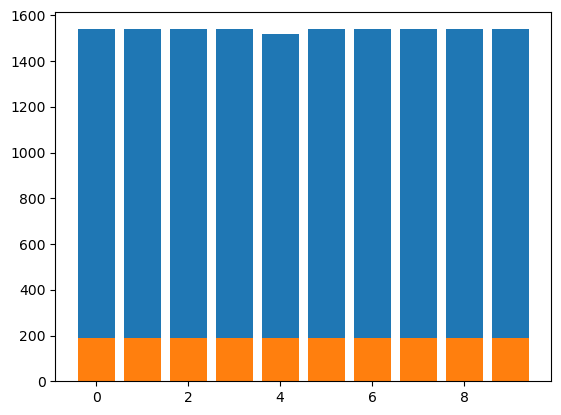

In [10]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Custom CNN (Melspectrogram version)

In [11]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
    x = Dropout(0.25)(x)
    return x

def conv_block_pad(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
    x = Dropout(0.25)(x)
    return x

In [12]:
#CNN+LSTM Model

def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block_pad(x, 64)
    x = conv_block_pad(x, 128)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Reshape((16,64))(x)
    
    #flatten process changed to the addition of 3 LSTM layers
    
    x = LSTM(units=128, dropout=0.05, return_sequences=True, input_shape=(8,128))(x)
    x = LSTM(units=128, dropout=0.05, return_sequences=True)(x)
    x = LSTM(units=64, dropout=0.05, return_sequences=False)(x)
    
    x = Dense(units=32, kernel_regularizer=tf.keras.regularizers.l1(0.01), activation='relu')(x)
 
    predictions = Dense(num_genres, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)

    model = Model(inputs=inpt, outputs=predictions)
    return model

In [13]:
model = create_model(X_train[0].shape, len(genres))

In [14]:
X_train[0].shape

(128, 129, 1)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 127, 16)      160       
                                                                 
 activation (Activation)     (None, 126, 127, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 32)        4640      
                                                             

### Loss function

In [16]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [18]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=150, validation_data=(X_valid, y_valid), shuffle=False)

Epoch 1/150
121/121 [==============================] - 14s 40ms/step - loss: 4.4545 - accuracy: 0.1784 - val_loss: 3.4509 - val_accuracy: 0.2678 - lr: 0.0010
Epoch 2/150
121/121 [==============================] - 4s 29ms/step - loss: 3.0154 - accuracy: 0.2174 - val_loss: 2.5269 - val_accuracy: 0.2912 - lr: 0.0010
Epoch 3/150
121/121 [==============================] - 4s 29ms/step - loss: 2.4532 - accuracy: 0.2567 - val_loss: 2.2618 - val_accuracy: 0.3058 - lr: 0.0010
Epoch 4/150
121/121 [==============================] - 4s 29ms/step - loss: 2.2745 - accuracy: 0.2804 - val_loss: 2.1700 - val_accuracy: 0.3117 - lr: 0.0010
Epoch 5/150
121/121 [==============================] - 4s 29ms/step - loss: 2.1861 - accuracy: 0.2903 - val_loss: 2.1112 - val_accuracy: 0.3199 - lr: 0.0010
Epoch 6/150
121/121 [==============================] - 4s 29ms/step - loss: 2.1295 - accuracy: 0.3068 - val_loss: 2.0562 - val_accuracy: 0.3251 - lr: 0.0010
Epoch 7/150
121/121 [==============================] - 3s

Epoch 52/150
119/121 [============================>.] - ETA: 0s - loss: 1.3151 - accuracy: 0.6587
Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.
121/121 [==============================] - 4s 29ms/step - loss: 1.3130 - accuracy: 0.6602 - val_loss: 1.4277 - val_accuracy: 0.6345 - lr: 9.5000e-04
Epoch 53/150
121/121 [==============================] - 4s 29ms/step - loss: 1.3021 - accuracy: 0.6666 - val_loss: 1.4095 - val_accuracy: 0.6398 - lr: 9.0250e-04
Epoch 54/150
121/121 [==============================] - 4s 29ms/step - loss: 1.3021 - accuracy: 0.6702 - val_loss: 1.3672 - val_accuracy: 0.6626 - lr: 9.0250e-04
Epoch 55/150
121/121 [==============================] - 4s 29ms/step - loss: 1.2888 - accuracy: 0.6731 - val_loss: 1.4000 - val_accuracy: 0.6421 - lr: 9.0250e-04
Epoch 56/150
119/121 [============================>.] - ETA: 0s - loss: 1.2626 - accuracy: 0.6830
Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0008573750033974647.
121/121 [======

121/121 [==============================] - 4s 29ms/step - loss: 0.7876 - accuracy: 0.8851 - val_loss: 1.2667 - val_accuracy: 0.7368 - lr: 3.7735e-04
Epoch 135/150
121/121 [==============================] - 4s 29ms/step - loss: 0.7841 - accuracy: 0.8837 - val_loss: 1.2954 - val_accuracy: 0.7398 - lr: 3.7735e-04
Epoch 136/150
121/121 [==============================] - 4s 29ms/step - loss: 0.7823 - accuracy: 0.8846 - val_loss: 1.2827 - val_accuracy: 0.7380 - lr: 3.7735e-04
Epoch 137/150
119/121 [============================>.] - ETA: 0s - loss: 0.7887 - accuracy: 0.8841
Epoch 137: ReduceLROnPlateau reducing learning rate to 0.00035848583793267607.
121/121 [==============================] - 4s 29ms/step - loss: 0.7872 - accuracy: 0.8846 - val_loss: 1.3674 - val_accuracy: 0.7292 - lr: 3.7735e-04
Epoch 138/150
121/121 [==============================] - 4s 29ms/step - loss: 0.7731 - accuracy: 0.8891 - val_loss: 1.3099 - val_accuracy: 0.7251 - lr: 3.5849e-04
Epoch 139/150
121/121 [============

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.289 and val_acc = 0.745


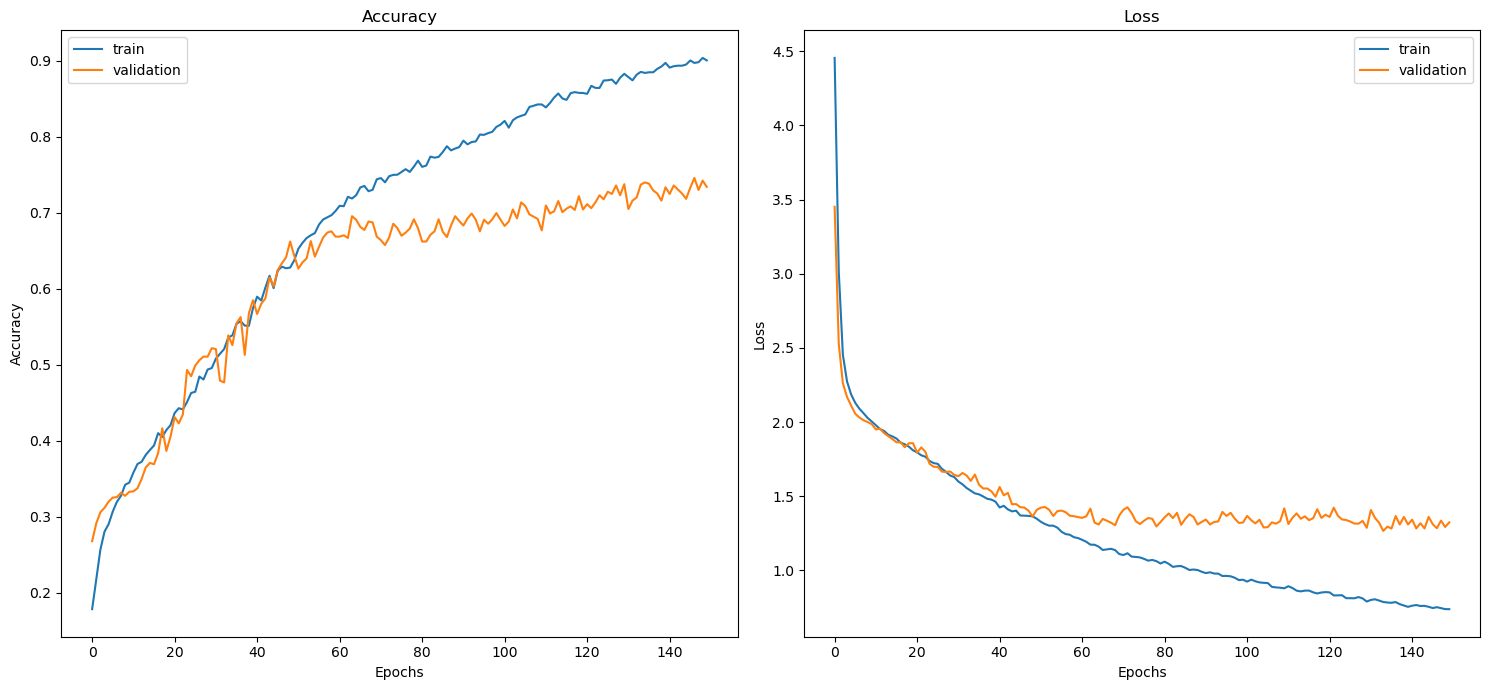

In [20]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

60/60 [==============================] - 2s 5ms/step


Normalized confusion matrix


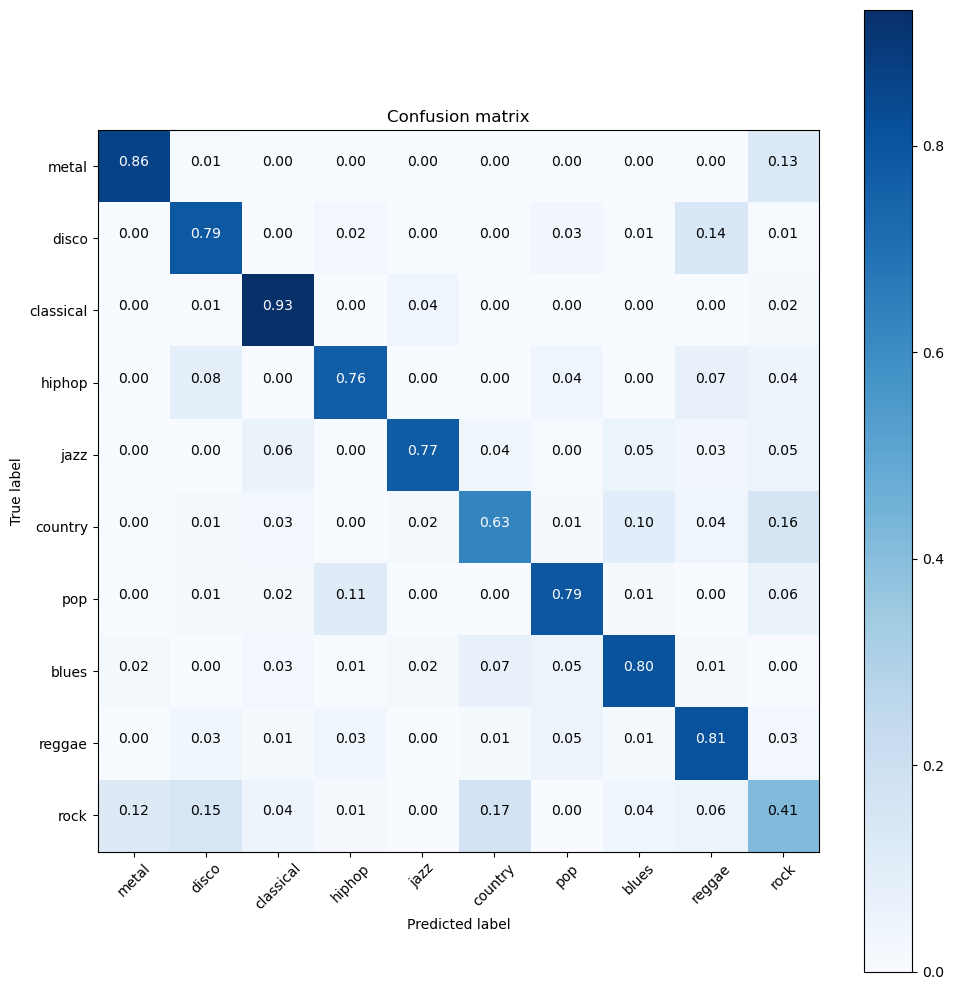

In [23]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

## Save the model

In [24]:
# Save the model
model.save('../models/custom_cnn_2d.h5')